# Problem description

## Goal

$\mathcal{D} = \{(\mathbf{x}_t, y_t) \}_{t=1}^N$ is a dataset containing $N$ pairs of input, $\mathbf{x}_t \in \mathbb{R}^d$, with its output, $y_t \in \mathbb{R}_{\ge 0}$, ordered by time $t$. Denote the data from year 2016 and 2018 as $\mathcal{D}^{2016}$ and $\mathcal{D}^{2018}$ respectively.

We split each of these datasets into two parts based on time. The first few weeks of each dataset are used for training + validation and the last few weeks for testing. In some experiments, the first few weeks of data from year 2018 are not used to train any models so they are also used for testing.

We want to check if the **relationship** between $\mathbf{x}_t$s and $y_t$s has changed over time.

**Notation**
We use **bold** font to denote a vector, **bold and capitalize** font to denote a matrix, and cursive font to denote a set. E.g., $\mathbf{x}_t$ is an input vector of $d$ dimensions, $y_t$ is a positive scalar, $\mathbf{X} \in \mathbb{R}^{m \times n}$ is a matrix of shape $m \times n$, and $\mathcal{D}$ is a set.

## Approach

### Background information

1. [Structural change](https://cran.r-project.org/web/packages/strucchange/vignettes/strucchange-intro.pdf) detection.
See also [this question](https://stats.stackexchange.com/questions/355920/how-to-test-if-the-process-that-generated-a-time-series-has-changed-over-time/358144#358144) where I asked how people in statistics handle this.

2. **Change point detection** (see [ruptures package and survey](https://github.com/deepcharles/ruptures), and [Bayesian online changepoint detection](https://github.com/hildensia/bayesian_changepoint_detection)) in CS and engineering.

3. **Concept drift** (see [survey1](http://www.win.tue.nl/~mpechen/publications/pubs/Gama_ACMCS_AdaptationCD_accepted.pdf),
[survey2](https://is.muni.cz/el/1433/podzim2011/PA164/um/drift_detection_methods.pdf)).

4. **Sequential Analysis: Hypothesis Testing and Changepoint Detection** by Alexander Tartakovsky.

The papers can be found online and in the links given above. I can share my private Github repository containing the code, papers and books if necessary.


### Further explanations and other options

Here are a few possible ways to approach this problem.

1. Given a sequence of data, most structural change algorithm maintain a set of test statistics obtained from the data stream and check at each time step if these test statistics have changed significantly. 

2. Related to 1., check the errors (predictions - actual) has changed over time given the predictions from a model trained on year 2016 data. 

3. Train two models, one each for 2016 and 2018 data, and test if they are approximately the same. This requires a way to compare models. 
   
    One possibility is to fit a Gaussian Process (GP) to $\mathcal{D}^{2016}$ and another to $\mathcal{D}^{2018}$ and compare these two models using either the Kullback-Leibler divergence or something like ["A Kernel Independence Test for Random Processes" by Chwialkowski and Gretton](http://proceedings.mlr.press/v32/chwialkowski14.pdf)
or ["Learning from uncertain curves: The 2-Wasserstein metric for Gaussian processes" by Mallasto and Feragan](https://papers.nips.cc/paper/7149-learning-from-uncertain-curves-the-2-wasserstein-metric-for-gaussian-processes.pdf).
    
    Note that changing the hyperparameters of these models can produce different models that perform similarly on the training, validation and test data. So this method, like almost all methods listed here, will be sensitive to the settings of these hyperparameters.

4. If you do not care about **detecting changes in the relationship** between $\mathbf{x}_t$ and $y_t$ and is OK with just noticing that the patterns observed in the $\mathbf{x}_t$ has changed over time, then we can use methods based on Topological Data Analysis (TDA) to detect changes in the structure of the point cloud formed by the collection of $\mathbf{x}_t$. See [GUDHI](http://gudhi.gforge.inria.fr/), [UMAP](https://github.com/lmcinnes/umap), [R-TDA](https://cran.r-project.org/web/packages/TDA/index.html).

5. Related to point 2 and 4, we can test if $\mathcal{D}^{2016}$ and $\mathcal{D}^{2018}$ are generated from the same distribution. One way is to use [Maximum Mean Discrepancy (MMD)](http://shogun-toolbox.org/notebook/latest/mmd_two_sample_testing.html). MMD bypass the need to fit the data to a  member of a **specific family** of distribution. This is a more general version of point 2 (where a GP is used to model this distribution). The weakness of this approach, like point 4, is that it does not model the relationship between the $\mathbf{x}_t$ and the $y_t$ but instead tells you if the $\mathbf{x}_t$ in 2016 is "different" from those in 2018.
   Also, the choice of kernel function and its parameters affect the results and scalablility of MMD.   

Each of these methods has its weaknesses and strengths. 

## Summary of *this* notebook

1. We visualize the output of the chiller to visually check for any significant structure that we can exploit.
        
    - For days in the same month, the output for each day is similar to those of other days. Sat and Sun's output 
      is a bit different from weekdays, possibly because the office hours are shorter.
    - Individual outputs (ch1kw, ch2kw, ch3kw) change between 2016 and 2018. If we have information pertaining 
      to these individual subsystems, we can do **multi-output** predictions to exploit the relationship 
      between these outputs rather than just predict their total.
    
2. We train a few algorithms/ML models to predict the output of the chiller system. This tests how well regression algorithms can predict the output of chiller, i.e., we check if there is
      reason to believe the $\mathbf{x}_t$s are related to the $y_t$.
      
3. We visualize the error of the models and observe that in general there is a change in the distribution of the error over time.

4. In general, the **errors in prediction are mostly concentrated around the time after the chillers have all shut down** (between 1130PM and 8AM).

5. The XGBoost (a non-linear tree-based) regressor performs the best at minimizing the mean absolute error for the 2016 data, followed by GP, then the Ridge regression model. For 2018 data, their MAE is more or less the same, with XGBoost somewhat worse as it appears to have overfitted the training data. However, as we mention below, if the target (total KW power) is noisy, it does not make sense to push for 0 MAE.

    
## <font color="red">Things to note</font>

1. Almost all ML algorithms have hyperparameters that we need to set. **Different** hyperparameter settings can give the same training error and even validation error but very different test error.
What this says is that the same algorithm can give **very different** models for different hyperparameters but you won't know beforehand because based on the training and validation error they all look the same and hence  can produce very different conclusions when given the test data.

2. Related to 1., if the total power is **noisy**, then it does **not** necessarily make sense to consider models with smaller error as better than those with larger errors because they might be fitting the noise in the training and validation data.

3. Extra knowledge about the structure of the problem can help improve the modeling process. For e.g., knowing when the system starts and shuts down each day can allow us to enforce condition that across days at the same period of time the predicted power should be close.

4. Typically we have a training set, a **validation** set, and a **test** set. It is **incorrect to tune your models' hyperparameters on the test set** as this is essentially fitting your model to the test data.

5. Because you are **dealing with timeseries** data, you **cannot** randomly select individual data points to form the training, validation and test dataset. The **reason** is that for timeseries data, data points close in time are very similar, sometimes even close to identical, so splitting the dataset this way will likely lead to examples in the test set to be near identical to those in the training set. This is a subtle cause of **data leakage** and will give the **false impression** that the model is doing well when in reality it might be much worse.

    The **correct** way is to do [walk-forward validation](Walk-Forward Validation). Datasets obtained this way can be generated using [TimeSeriesSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) from a package such as [Scikit-Learn](http://scikit-learn.org/). Further description can be found in [this blog post by Rob Hyndman](https://robjhyndman.com/hyndsight/tscv/).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools

plt.rcParams.update({'font.size': 22})

import GPy
import GPyOpt

from sklearn.linear_model import Ridge, RidgeCV

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("ggplot")
%matplotlib inline

from IPython.display import display_html
def display_side_by_side(*args):
    """Display two Pandas DataFrame side-by-side.
    Taken from https://stackoverflow.com/questions/38783027/
               jupyter-notebook-display-two-pandas-tables-side-by-side
    """
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)


import matplotlib.ticker as ticker
from matplotlib.dates import MO, SA
from matplotlib.dates import WeekdayLocator
import matplotlib.dates as plt_dates
def plot_model_error(y, pred, pred_variance=None, figsize=(22, 12), title=None):
    """Plot the groundtruth, model prediction, and model error (prediction - groundtruth)
    """
    
    index = y.index

    y = np.asarray(y).ravel()
    pred = np.asarray(pred).ravel()
    error = pred - y
    mean_error = (np.abs(error)).mean() # mean_absolute_error(y, pred)

    y = pd.Series(y, index=index)
    pred = pd.Series(pred, index=index)
    error = pd.Series(error, index=index)

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=figsize)

    # Draw region of uncertainty if variance is given (for GP)
    if pred_variance is not None:
        sd = pd.Series(np.sqrt(pred_variance.squeeze()), index=index)
        axes[0].fill_between(index, pred - sd, pred + sd, alpha=0.4, color="magenta")
        
    # Plot true output, predicted output, and error (i.e., prediction - true output)
    y.plot(color="green", label="Ground truth", ax=axes[0])
    pred.plot(color="blue", alpha=0.6, label="Prediction", ax=axes[0])
    error.plot(color="red", label="Error", ax=axes[1])
    
    # Save lines and labels for true output and predictions
    lines, labels = axes[0].get_legend_handles_labels()

    # Mark 0 KW with a dotted line
    axes[1].axhline(0, color="black", linestyle="--")
    
    # Set tick font size and rotation
    axes[0].tick_params(axis='both', which='major', labelsize=14, rotation=0)
    axes[1].tick_params(axis='both', which='major', labelsize=14, rotation=0)

    # Plot vertical lines and color regions to mark special times of each day
    marked_saturday = False
    grouped_by_day = error.groupby(index.dayofyear)
    for i, (k, g) in enumerate(grouped_by_day):
                
        # Set specific times
        dt_start = g.index[0].replace(hour=8, minute=0, second=0, microsecond=0)
        dt_end = dt_start.replace(hour=19)  # 1 chiller shut down at ~1900
        dt_end2 = dt_start.replace(hour=21, minute=30)  # 2 more chillers shut down at ~2130
        dt_end3 = dt_start.replace(hour=23, minute=30)  # Last chiller shut down at ~1330
        dt_end_1PM = dt_start.replace(hour=13, minute=0) # Office hour ends at 1PM on Saturday
        
        # Draw lines on both plots
        for ax in axes.ravel():
            # Add label once (to only last point of day) so that we don't clutter legend
            if i == len(grouped_by_day) - 1:                
                ax.axvspan(dt_start, dt_end, color="yellow", alpha=0.2, label="Daytime")
                ax.axvspan(dt_end, dt_end2, color="black", alpha=0.3, label="Shutdown-stage1")
                ax.axvspan(dt_end2, dt_end3, color="black", alpha=0.5, label="Shutdown-stage2")
                ax.axvline(dt_start, color="green", linestyle="--", label="8AM")
                ax.axvline(dt_end, color="magenta", linestyle="--", label="7PM")
                ax.axvline(dt_end2, color="cyan", linestyle="--", label="930PM")
                ax.axvline(dt_end3, color="black", linestyle="--", label="1130PM")
            else:
                ax.axvspan(dt_start, dt_end, color="yellow", alpha=0.2)
                ax.axvspan(dt_end, dt_end2, color="black", alpha=0.3)
                ax.axvspan(dt_end2, dt_end3, color="black", alpha=0.5)
                ax.axvline(dt_start, color="green", linestyle="--")
                # Mark Saturday and Sunday. Monday == 0, Saturday == 5, Sunday == 6                
                if dt_start.weekday() == 5:
                    if not marked_saturday:
                        ax.axvspan(dt_start, dt_end_1PM, color="white", alpha=0.8, label="Sat-hours")
                        ax.axvline(dt_end_1PM, color="blue", linestyle="--", label="1PM")                        
                    else:
                        ax.axvspan(dt_start, dt_end_1PM, color="white", alpha=0.8)
                        ax.axvline(dt_end_1PM, color="blue", linestyle="--")                
                ax.axvline(dt_end, color="magenta", linestyle="--")
                ax.axvline(dt_end2, color="cyan", linestyle="--")
                ax.axvline(dt_end3, color="black", linestyle="--")
            
        # Indicate already labeled Saturday
        if dt_start.weekday() == 5:
            marked_saturday = True
    
    # Add lines from error plots to legend
    ln, lb = axes[1].get_legend_handles_labels()
    lines.extend(ln)    
    labels.extend(lb)
    # Set up legend in a fancy box at the top
    fig.legend(lines, labels, loc="lower center", ncol=12,
#                bbox_to_anchor=(0.5, -0.20),
               fancybox=True, shadow=True,
               fontsize=14)    

    # Show tick only on Mondays and Saturdays
    loc = WeekdayLocator(byweekday=(MO, SA))
    axes[1].xaxis.set_major_locator(loc)    
    for tick in axes[1].xaxis.get_major_ticks():
        tick.label1.set_horizontalalignment('left')
    axes[1].xaxis.set_major_formatter(plt_dates.DateFormatter('%a %b %-d'))
    
    if title is None:
        title = "Mean error: {:.3f}".format(mean_error)
    else:
        title += " - Mean error: {:.3f}".format(mean_error)

    fig.suptitle(title, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]);

def plot_cumul_error(y, pred, title=None, figsize=(21, 4), ax=None, **kwargs):
    """Plot cumulative error of the model"""
    
    index = y.index

    error = np.asarray(pred.ravel()) - np.asarray(y.ravel())
    error = pd.Series(error, index=index)
    cum_error = pd.Series(data=np.cumsum(error), name="Cumul. Error", index=index)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig = ax.figure

    cum_error.plot(ax=ax, color="red")
    ax.axhline(0, 0, 1, color="black", linestyle="--")
    ax.tick_params(axis='both', which='major', labelsize=14)

    if title is not None:
        ax.set_title(title, fontsize=20)
    ax.legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

def plot_outputs(df, figsize=(18, 18), title=None):
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=figsize)

    total = df.ch1kw + df.ch2kw + df.ch3kw
    max_output = total.max()
    for i, ax in enumerate(axes[:3], 1): # in range(3):
        column = "ch{}kw".format(i)
        df[column].plot(ax=ax, title="ch{}kw".format(i), label=column)
        ax.legend()

    total.plot(ax=axes[3], title="Total", label="Total output", color="blue")
    axes[3].axhline(total.mean(), linestyle="--", color="black", label="Mean")

    # Draw vertical line at 8AM and 7PM
    grouped_total_power = total.groupby(total.index.dayofyear)
    for i, (k, g) in enumerate(grouped_total_power):
        dt = g.index[0]
        dt_start = dt.replace(hour=8, minute=0, second=0, microsecond=0)
        dt_end = dt.replace(hour=19, minute=0, second=0, microsecond=0)
        if i == len(grouped_total_power) - 1:
            axes[3].axvline(dt_start, color='green', linestyle='--', label="8AM")
            axes[3].axvline(dt_end, color='red', linestyle='--', label="7PM")
        else:
            axes[3].axvline(dt_start, color='green', linestyle='--')
            axes[3].axvline(dt_end, color='red', linestyle='--')

    tick_spacing = 50
    axes[3].yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    axes[3].legend()

    if title is not None:
        fig.suptitle(title)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Setup

## Global parameters

In [2]:
N_TIMESERIES_SPLITS = 5
BO_RAND_STATE = 777
SCORE_TYPE = "neg_mean_absolute_error"

## Get data 

Note that the data have been preprocessed earlier in another Jupyter notebook to remove entries with missing data (indicated as "\\N" in csv file). This is why there are some gaps in the observations shown in the plots below.

In [3]:
df1 = pd.read_csv("../data/insead_2016_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")
df2 = pd.read_csv("../data/insead_2018_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")

display_side_by_side(df1.head(2), df2.head(2))

chwshdr 
 cwrhdr 
 cwshdr 
 cwsfhdr 
 ch1kw 
 ch2kw 
 ch3kw 
 loadsys 
 chwsfhdr 
 ch1_status 
 ch2_status 
 ch3_status 
 totalkw 
 
 
 timestamp 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2016-02-01 00:00:00 
 0.00000 
 30.4664 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0 
 0 
 0 
 0.000 
 
 
 2016-02-01 00:01:00 
 8.46289 
 30.3218 
 27.143 
 536.522 
 0.844 
 0.856 
 82.944 
 113.924 
 407.278 
 0 
 0 
 1 
 84.644 
 
 
 
 
 
 
 chwshdr 
 cwrhdr 
 cwshdr 
 cwsfhdr 
 ch1kw 
 ch2kw 
 ch3kw 
 loadsys 
 chwsfhdr 
 ch1_status 
 ch2_status 
 ch3_status 
 totalkw 
 
 
 timestamp 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2018-04-01 00:00:00 
 0.0000 
 0.0000 
 0.0000 
 576.223 
 42.24 
 0.848 
 0 
 95.6832 
 486.972 
 1 
 0 
 0 
 43.088 
 
 
 2018-04-01 00:01:00 
 10.7674 
 28.8237 
 26.3996 
 579.979 
 42.24 
 0.852 
 0 
 96.2943 
 486.091 
 1 
 0 
 0 
 43.092

In [4]:
df1.shape, df2.shape

((81623, 13), (53147, 13))

## Separate into feature and target

In [5]:
features = [
"chwshdr",
"cwrhdr",
"cwshdr",
"cwsfhdr",
"loadsys",
"chwsfhdr", 
]

status_features = [
"ch1_status",
"ch2_status",
"ch3_status"    
]

target = ["totalkw"]

In [6]:
# Assign features and targets
y1 = df1.totalkw
y2 = df2.totalkw
X1 = df1[features]
X2 = df2[features]

## Split into train and test data

Let's count the number of data points we have per week of each year.

In [7]:
# Number of days in each week in the two datasets
display_side_by_side(df1.groupby(df1.index.week).size().to_frame(name="Number of examples per week (2016)"),
                     df2.groupby(df2.index.week).size().to_frame(name="Number of examples per week (2018)"))

Number of examples per week (2006) 
 
 
 timestamp 
 
 
 
 
 
 5 
 10065 
 
 
 6 
 10046 
 
 
 7 
 10062 
 
 
 8 
 6247 
 
 
 9 
 9710 
 
 
 10 
 9746 
 
 
 11 
 9930 
 
 
 12 
 10066 
 
 
 13 
 5751 
 
 
 
 
 
 
 Number of examples per week (2008) 
 
 
 timestamp 
 
 
 
 
 
 13 
 1437 
 
 
 14 
 10049 
 
 
 15 
 10058 
 
 
 16 
 10059 
 
 
 17 
 10054 
 
 
 18 
 10054 
 
 
 19 
 1436

Then we split each dataset into two parts. The first contain the **first 4 weeks**, and the second contain the rest.
We also show the number of examples in each resulting dataset.

In [7]:
N_TRAIN_WEEKS = 4  # First few weeks are used for training, rest for test.

X1_train = X1.iloc[X1.index.week < X1.index.week[0] + N_TRAIN_WEEKS]
X1_test = X1.iloc[X1.index.week > X1_train.index.week[-1]]

y1_train = y1.iloc[X1.index.week < X1.index.week[0] + N_TRAIN_WEEKS]
y1_test = y1.iloc[X1.index.week > X1_train.index.week[-1]]

X2_train = X2.iloc[X2.index.week < X2.index.week[0] + N_TRAIN_WEEKS]
X2_test = X2.iloc[X2.index.week > X2_train.index.week[-1]]

y2_train = y2.iloc[X2.index.week < X2.index.week[0] + N_TRAIN_WEEKS]
y2_test = y2.iloc[X2.index.week > X2_train.index.week[-1]]

dataset_counts = pd.DataFrame(((name, len(x))
                               for x, name in zip((X1_train, X1_test, X2_train, X2_test),
                                                  ("Train (2016)", "Test (2016)",
                                                   "Train (2018)", "Test (2018)"))))
dataset_counts.set_index(0).T

0  Train (2006)  Test (2006)  Train (2008)  Test (2008)
1         36420        45203         31603        21544

## Visualize output of chiller

Let's visualize the output for the dataset from year **2016**.

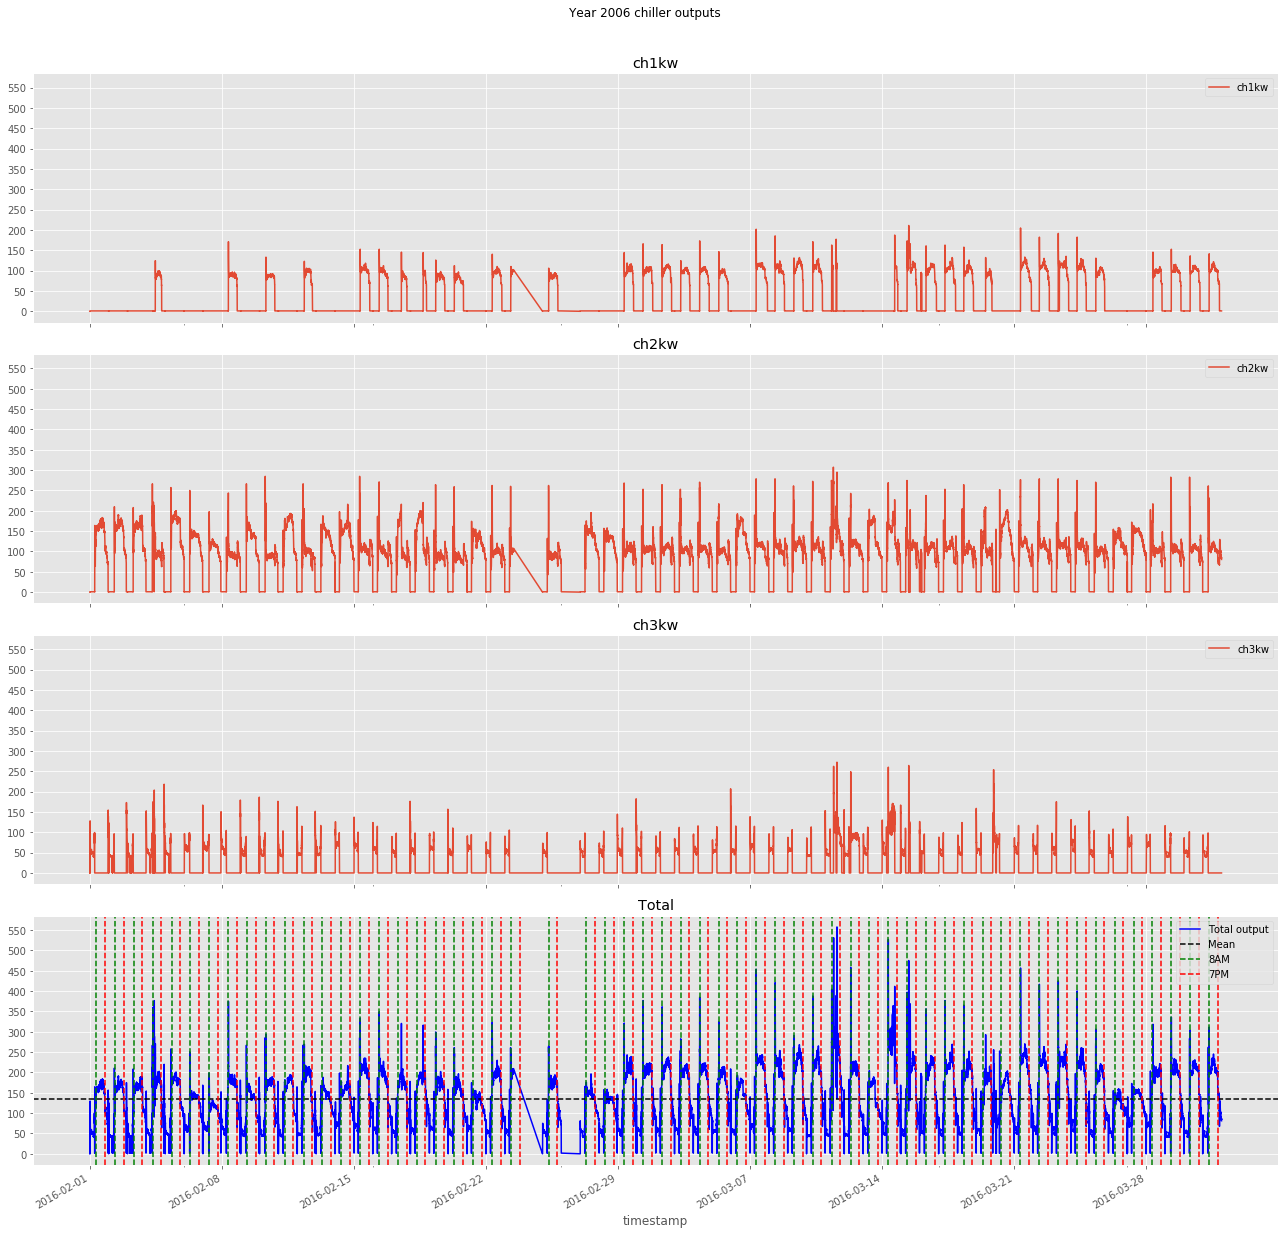

In [69]:
plot_outputs(df1, title="Year 2016 chiller outputs")

Next, we visualize the output for the dataset from year **2018**.

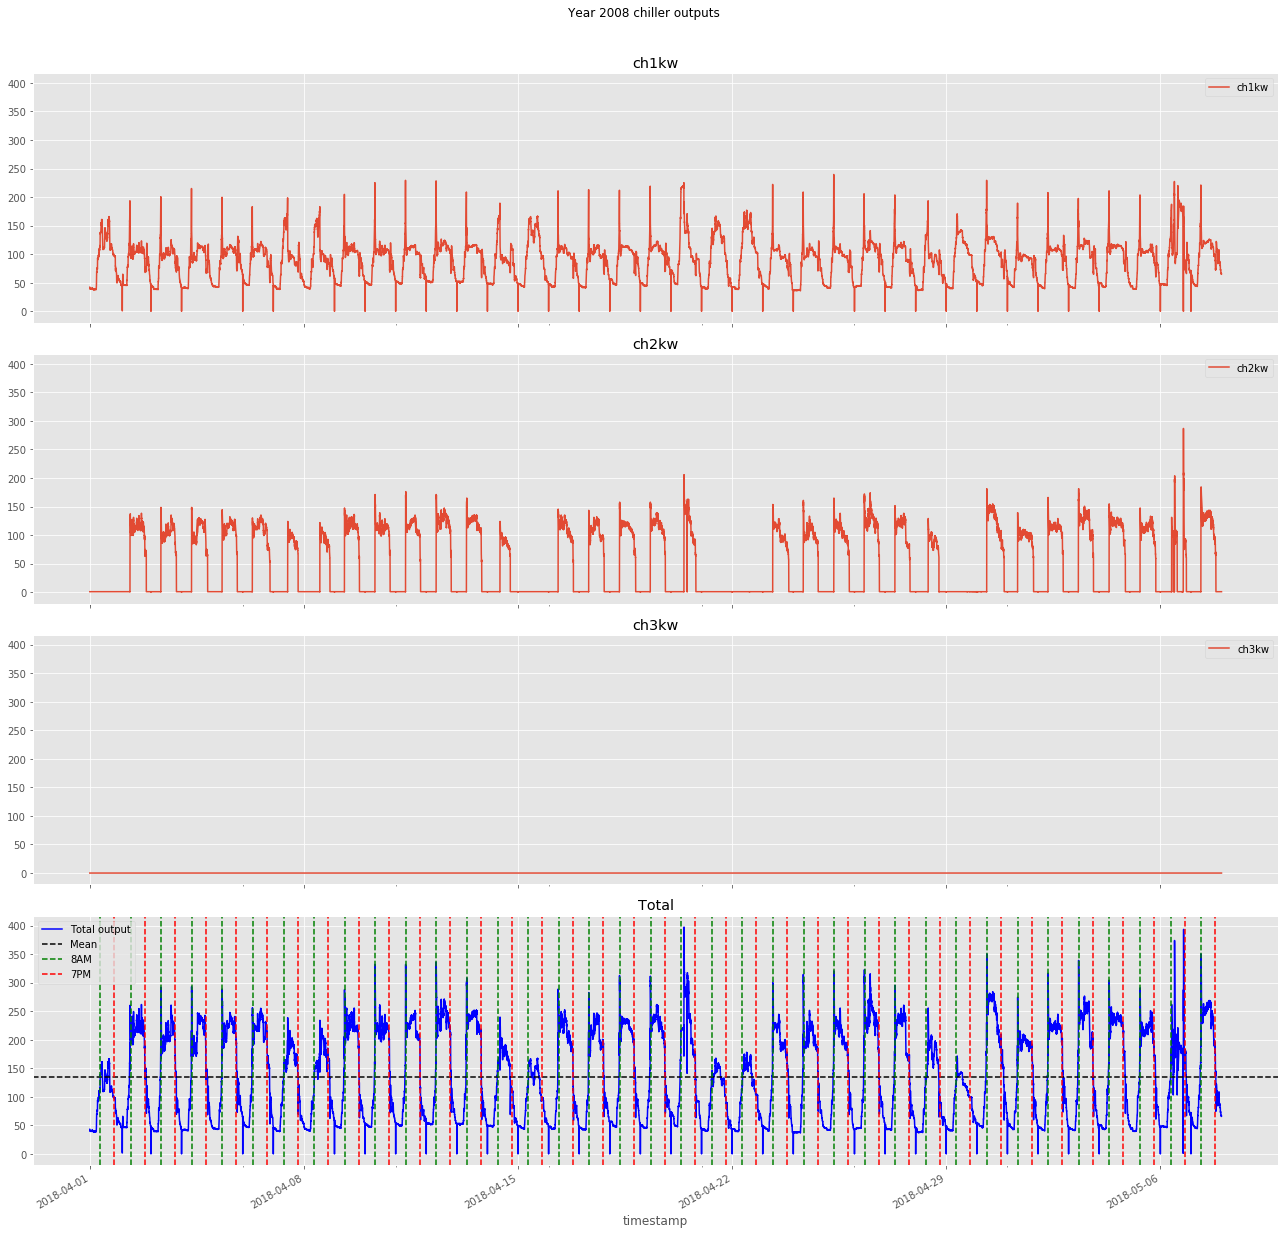

In [70]:
plot_outputs(df2, title="Year 2018 chiller outputs")

It is worth noting that pattern does not only change in the total, but also in the individual outputs "ch1kw", "ch2kw" and "ch3kw".

The mean total power is roughly the same (slightly less than 150) for both years, but the **peak daily total power** seems to be much higher in 2016's data. 

Could this be due to
1. Aging equipment,
2. data being collected on different month and year (temperature different) and/or
3. changes in system configuration?

Note: this [weather map](http://www.weather.gov.sg/climate-detailed-view/) of Singapore suggests that it was **much hotter in April 2018 than February 2016**.

There is a chunk of consecutive missing data in 2016. There should also be some missing data in 2018, but these are sporadic, and is less of a problem. In general this is a problem only for models that model the data as sequence. 

Lastly note that the range of the x-axis for the 2016 and 2018 datasets are different so one plot is more "compressed" along the x-axis.

---

# Build models

Here we train various models on data from the first few weeks of the dataset from year **2016** to predict the total output of the chiller. Each of these model represents the relationship between the inputs and outputs in year 2016. 

We will use these models to predict the output using the data in year 2016 (later part) and 2018 and check if the error of prediction follows a different pattern.

Intuitively we are checking for the following cases

1. Errors in 2016 and 2018 do not differ by much, i.e., chiller has not changed/aged.
2. Predictions generally **larger** than recorded output (over prediction).
3. Predictions generally **smaller** than recorded output (under prediction).
4. Sporadic large errors (anomalies).

The hyperparameters are selected using [Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) to maximize the performance using **walk forward cross validation**.

**Note**:
Models have hyperparameters and different hyperparameters may result in different models with same training error but different test error. Therefore this approach in general can be sensitive to how the hyperparameters are set and **can lead to different conclusion** about the state of the chiller. This is why it was mentioned earlier that this approach might not be a good one.

## Ridge regression

This is linear regression with $L_2$ regularization, also known as ridge regression.

We are finding the best linear predictor for $\lambda > 0$

$$
\mathbf{w}_{\text{opt}} = \underset{\mathbf{w}}{\text{argmin}} \sum_{t = 0}^N \lvert\lvert \mathbf{w}^T \mathbf{x}_t - y_t \rvert\rvert^2_2 + \lambda \lvert\lvert \mathbf{w} \rvert\rvert^2_2
$$

Best alpha param: 0.001


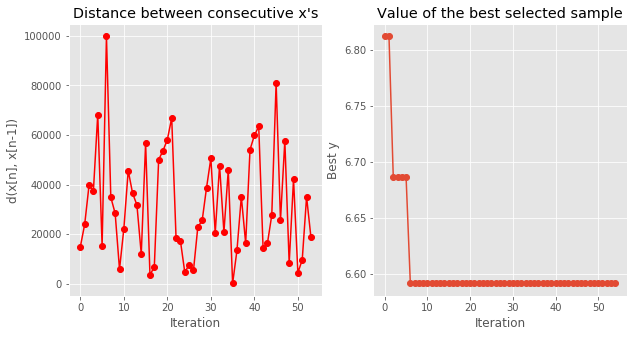

In [48]:
# Set up Bayesian Optimization
def f_lr(params, X, y, cv):
    params = params[0]
    score = -cross_val_score(Ridge(alpha=params[0]),                              
                             X, y,
                             cv=cv,
                             scoring=SCORE_TYPE).mean()
    return np.array(score)

np.random.seed(BO_RAND_STATE)
f = functools.partial(f_lr, X=X1_train, y=y1_train, 
                      cv=TimeSeriesSplit(n_splits=N_TIMESERIES_SPLITS))
lr_domains = [{'name': 'alpha', 'type': 'continuous', 'domain': (1e-3, 1e5)}]
optimizer = GPyOpt.methods.BayesianOptimization(f=f, 
                                                domain=lr_domains,
                                                acquisition_type='EI', # "LCB" works better
                                                acquisition_par=0.2,
                                                exact_feval=False)
optimizer.run_optimization(max_iter=50)
print("Best alpha param: {}".format(optimizer.x_opt[0]))

optimizer.plot_convergence()

### Plot errors

Note that 2016 (early part) is also the **training** data.

In [71]:
lr = Ridge(alpha=optimizer.x_opt[0])
lr.fit(X1_train, y1_train)

y1_train_pred = lr.predict(X1_train)
y2_train_pred = lr.predict(X2_train)
y1_test_pred = lr.predict(X1_test)
y2_test_pred = lr.predict(X2_test)

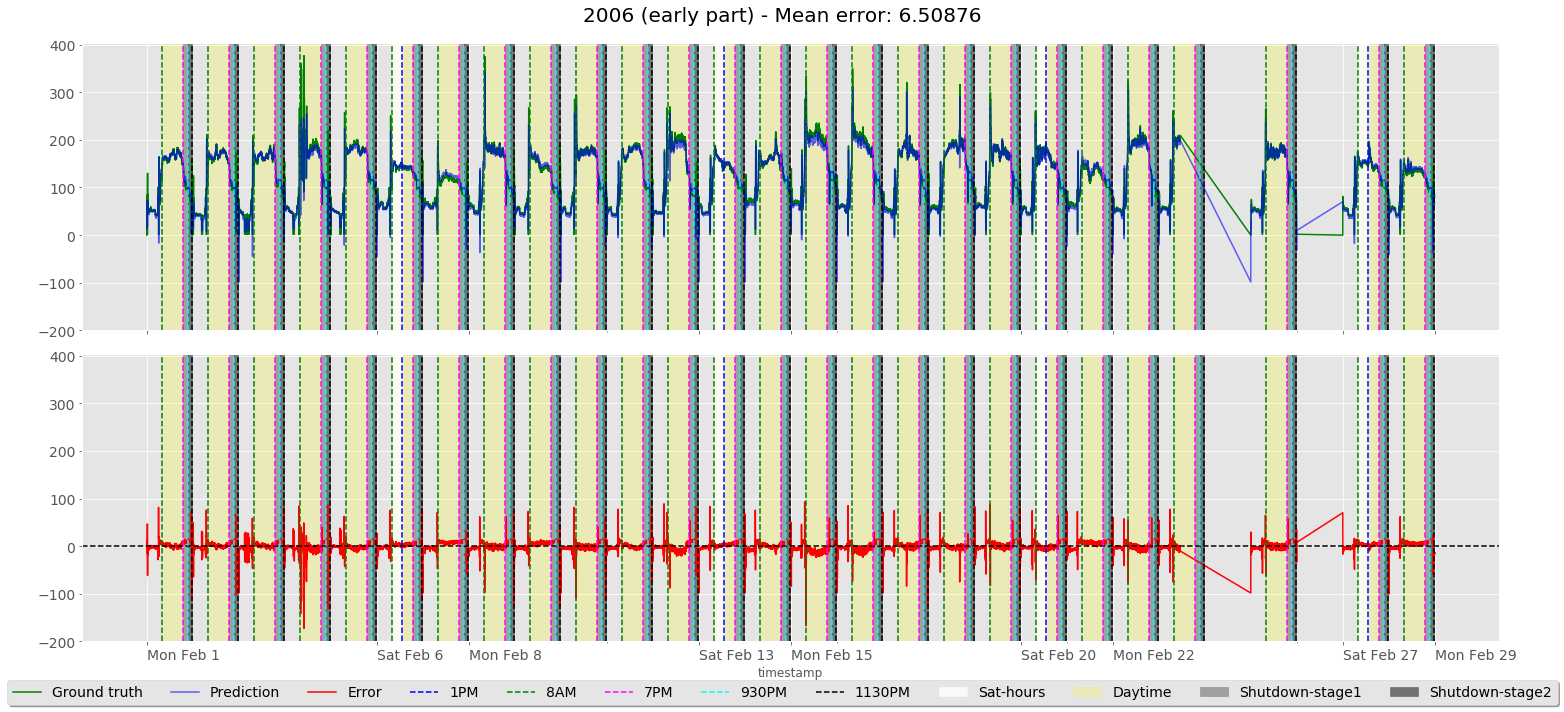

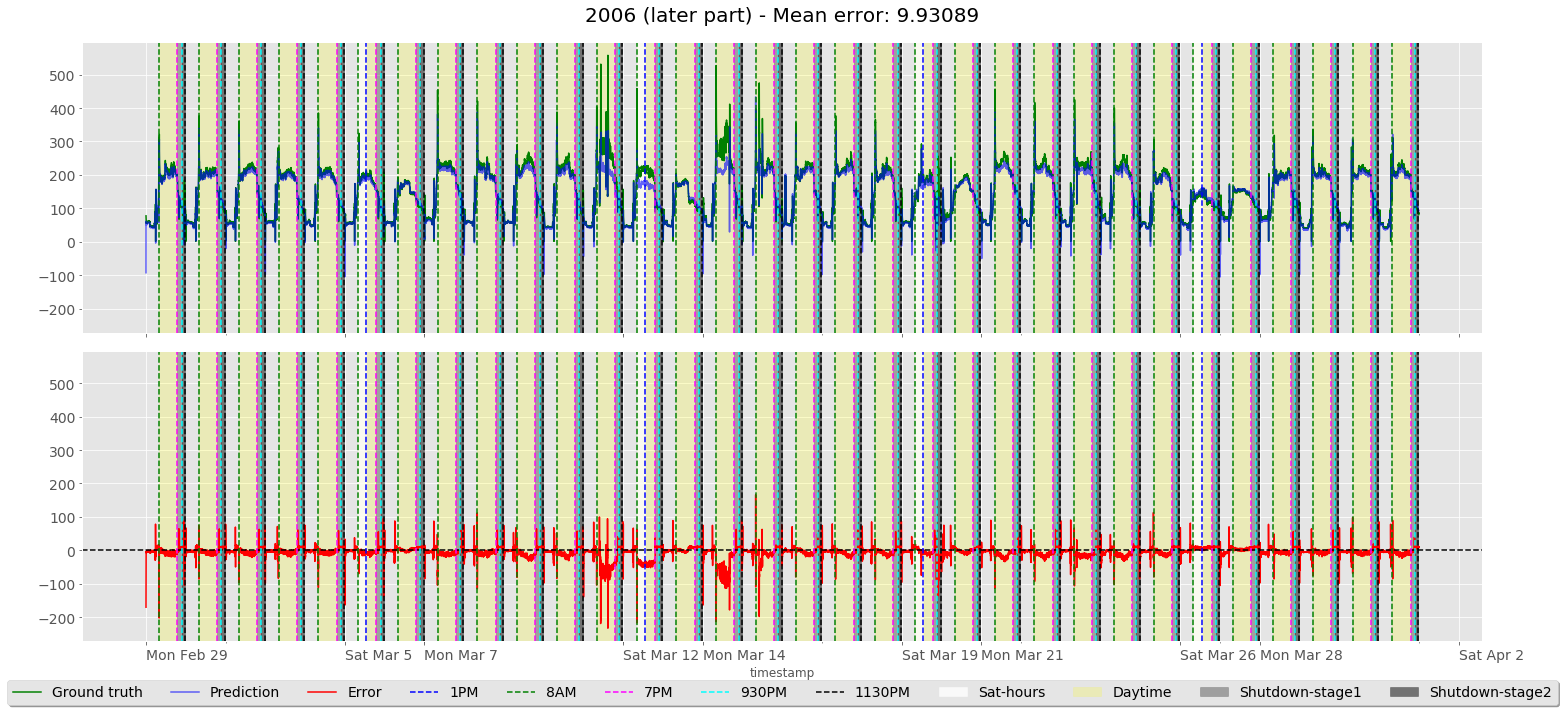

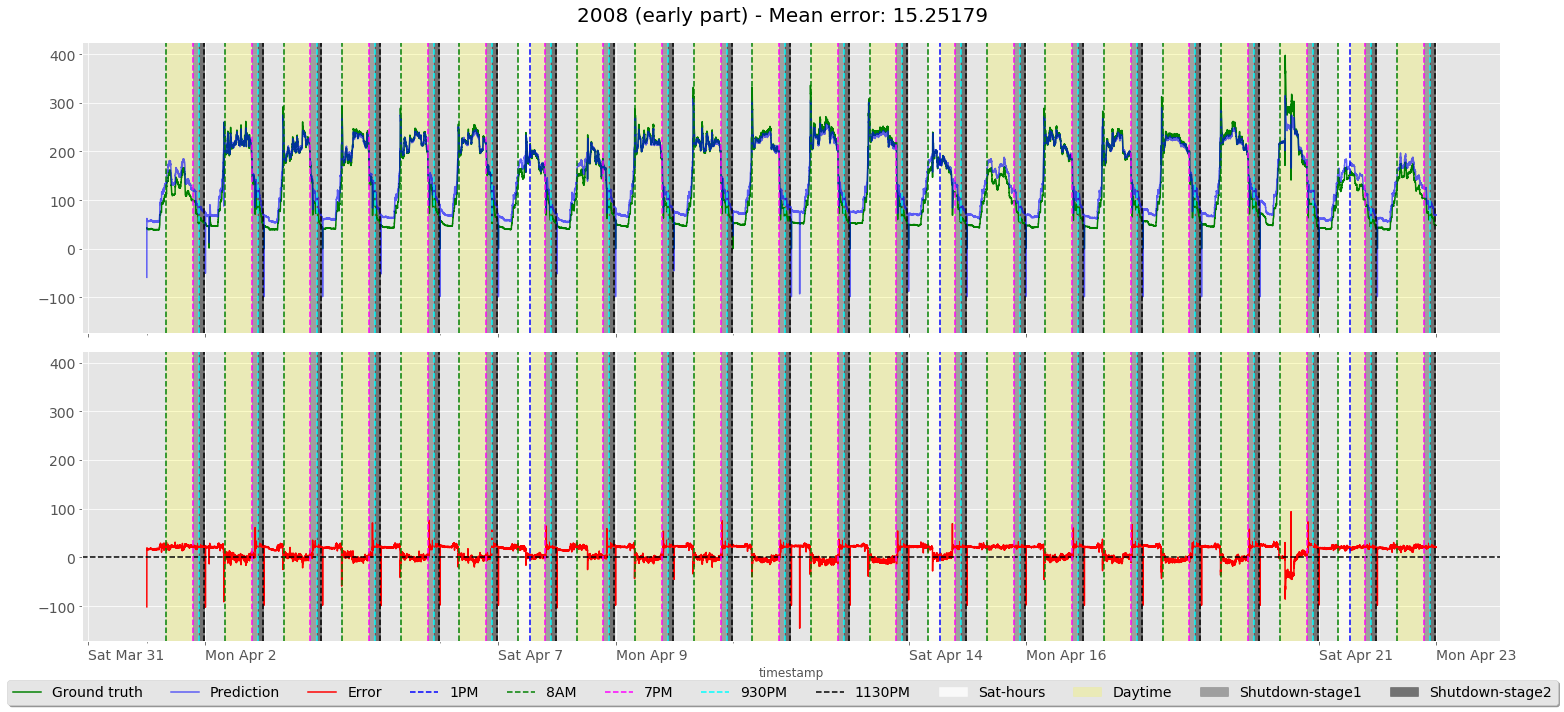

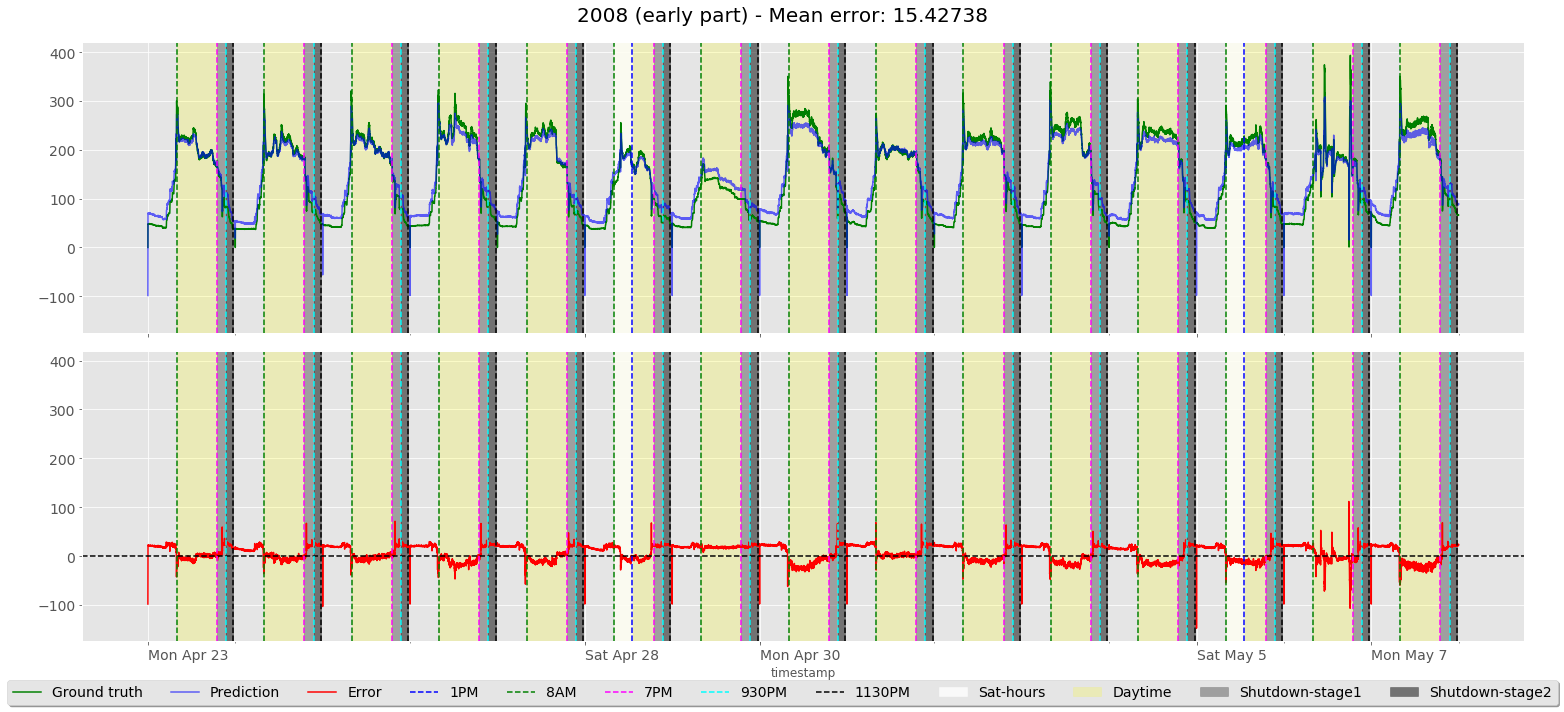

In [72]:
plot_model_error(y1_train, y1_train_pred, title="2016 (early part)")
plot_model_error(y1_test, y1_test_pred, title="2016 (later part)")
plot_model_error(y2_train, y2_train_pred, title="2018 (early part)")
plot_model_error(y2_test, y2_test_pred, title="2018 (early part)")

Prediction by model is in <font color="blue">**blue**</font>, actual is <font color="green">**green**</font>. Their difference (error = prediction - actual) is in <font color="red">**red**</font> at the bottom.

The colored dotted vertical lines correspond to time **8AM** (<font color="green">**green**</font>), **7PM** (<font color="magenta">**magenta**</font>),  **930PM** (<font color="cyan">**cyan**</font>), and **1130PM** (<font color="black">**black**</font>). The white regions corresponds to **Sat 8AM to 1PM**.
These times are taken from the paper "Energy Optimization of an In-Service Building Chiller Plant via Extremum Seeking Control" by Vu et al. and correspond respectively to start up, 2 chillers shutdown, 1 more chiller shutdown, and finally last chiller shutdown for Chinatown Point (CPT).

**Note: The timing given in the paper is for the 4 chillers from Chinatown Point but our dataset is collected from INSEAD's 3 chillers**. However, based on the plots we see that these times are also relevant for INSEAD as they match well with the changes in the output.

**Key observations**:

- Most of the **errors occur near the startup and after the first 2 chillers shut down after 7PM**. 

- Strangely **there is still power even after the final chiller shuts down at 1130PM **. Is this the ~30KW power mentioned in Dr Chai's email?

- We see that this model in general **under predicts in the period after 7PM (grey)** for the year 2016 test data (top) and **over predicts** for 2018 data (middle 2 and bottom 2 figures). <font color="red">**We need to consult Dr Chai to under why this is so and whether we can exploit this phenomenon.**</font>

The system is not modeling the startup and shut down phases well. Having extra information (e.g., extra inputs or knowledge from logs) can help us build more sophisticated models to reduce errors in such cases.

### Plot cumulative error

These plots show the cumulative sum of the error plots over time (red lines above). **If there is no systemic over/under prediction, the cumulative error should cancel out over time and hover near 0**. This is the key idea behind some structural change algorithms.

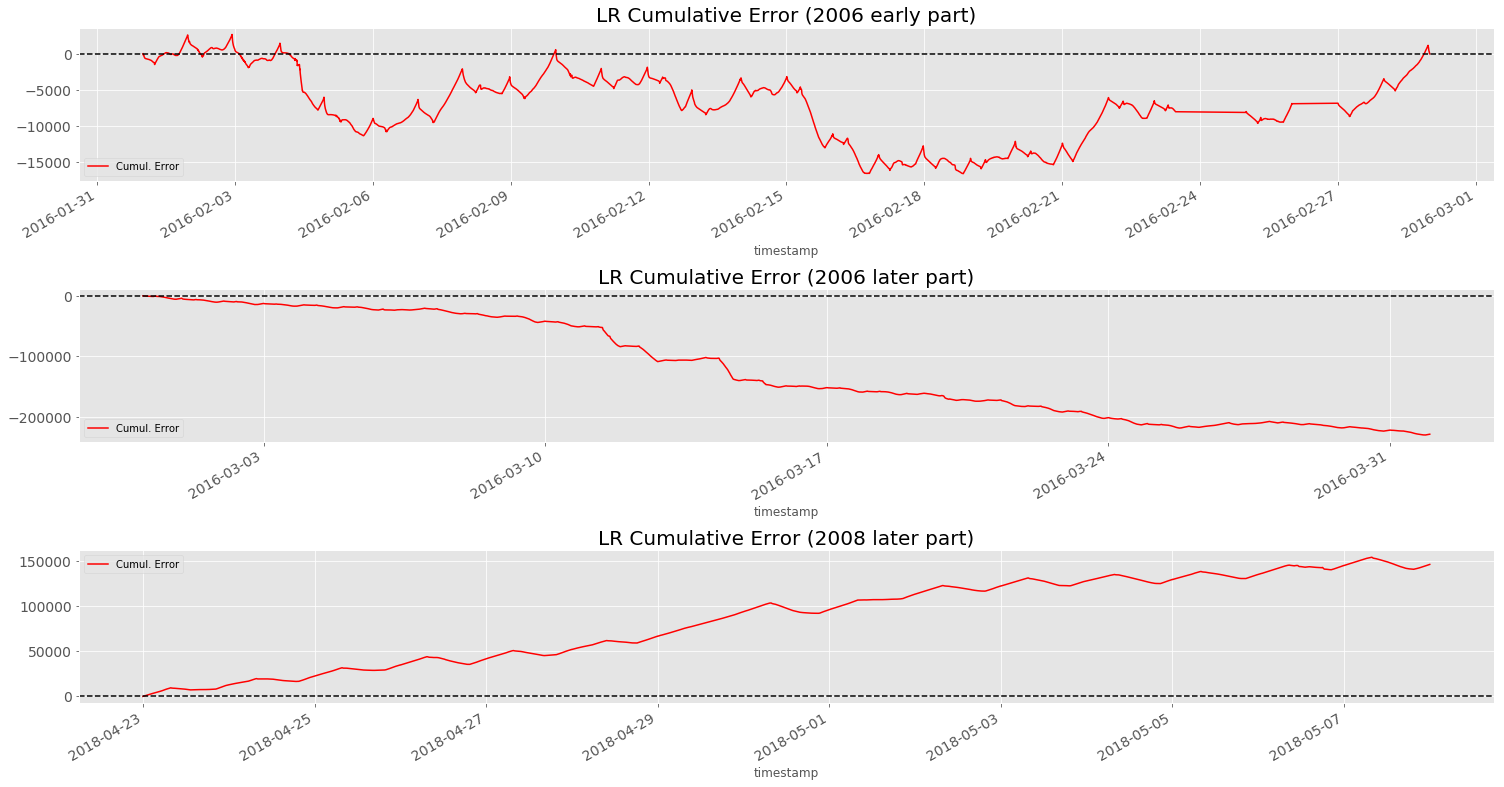

In [73]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cumul_error(y1_train, y1_train_pred, "LR Cumulative Error (2016 early part)", ax=axes[0])
plot_cumul_error(y1_test, y1_test_pred, "LR Cumulative Error (2016 later part)", ax=axes[1])
plot_cumul_error(y2_test, y2_test_pred, "LR Cumulative Error (2018 later part)", ax=axes[2])

**Interpreting** the cumulative error line. If it 
1. is close to horizontal - there is little error for that period and they cancel out. 
2. drops - consistent under prediction.
3. rises - consistent over prediction.

When tested on data **not** used in training, the model is systematically **under predicting** for the later part of year 2016 data and **over predicting** for year 2018 data. You can verify this from the error plots in the figures shown earlier.

**What this means** is that even for data from the same year, this model will lead to a conclusion that there are changes in the system.

**Therefore, naively using the error in an algorithm such as CUSUM can lead to wrong conclusions.**

## XGBoost

We perform the same experiments as above but with the XGBoost regressor. This is a tree-based regressor. In general, it is a "high capacity" model unlike ridge regression and should give better results than ridge regression. We tune the hyperparameters using Bayesian optimization.

Best param: [  0.6        516.54779036  12.        ]


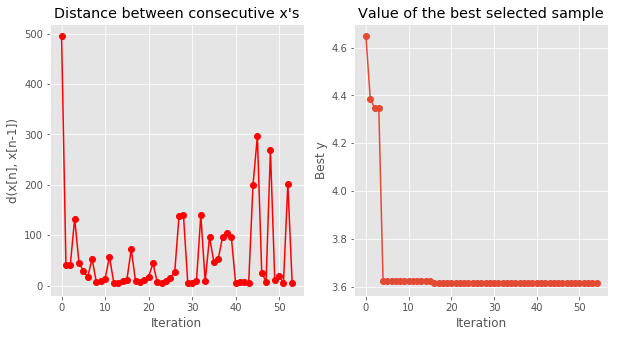

In [10]:
from xgboost import XGBRegressor

xgb_domains = [
    {
        "name": "colsample_bytree",
        "type": "continuous",
        "domain": (0.3, 0.6)
    },
    {
        "name": "reg_lambda",
        "type": "continuous",
        "domain": (0.1, 1e3)
    },
    {
        "name": "max_depth",
        "type": "discrete",
        "domain": (7, 12)
    },
]

def f_xgb(params, X, y, cv, random_state):
    params = params[0]
    score = -cross_val_score(XGBRegressor(
                                          n_estimators=200,
                                          max_depth=int(params[2]),
                                          learning_rate=0.1,
                                          colsample_bytree=params[0],
                                          reg_lambda=params[1],
                                          random_state=random_state,
                                          n_jobs=4
                                          ),
                             X, y,
                             cv=cv,
                             scoring=SCORE_TYPE).mean()
    return np.array(score)

np.random.seed(BO_RAND_STATE)
random_state = 1234
f = functools.partial(f_xgb, X=X1_train, y=y1_train, 
                      cv=TimeSeriesSplit(n_splits=N_TIMESERIES_SPLITS),
                      random_state=random_state)

optimizer = GPyOpt.methods.BayesianOptimization(f=f, 
                                                domain=xgb_domains,
                                                acquisition_type='EI',
                                                acquisition_par=0.2,
                                                exact_feval=False)


optimizer.run_optimization(max_iter=50)
print("Best param: {}".format(optimizer.x_opt))

optimizer.plot_convergence()

In [11]:
params = optimizer.x_opt
xgb = XGBRegressor(n_estimators=200,
                   max_depth=int(params[2]),
                   learning_rate=0.1,                                      
                   colsample_bytree=params[0],
                   reg_lambda=params[1],
                   random_state=random_state,
                   n_jobs=4)

xgb.fit(X1_train, y1_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=1234,
       reg_alpha=0, reg_lambda=516.547790360732, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

### Plot errors

Note that 2016 (early part) is also the **training** data.

In [12]:
y1_train_pred = xgb.predict(X1_train)
y2_train_pred = xgb.predict(X2_train)
y1_test_pred = xgb.predict(X1_test)
y2_test_pred = xgb.predict(X2_test)

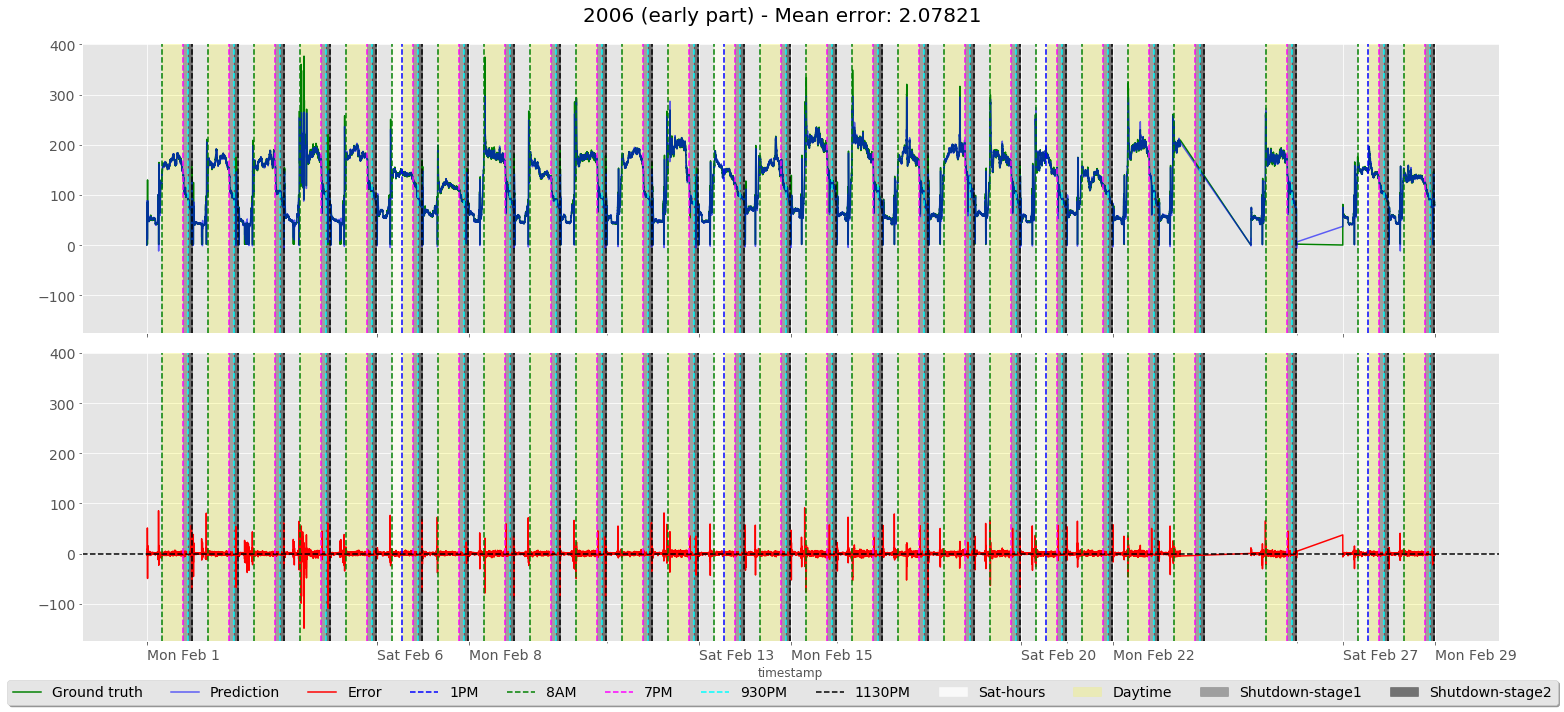

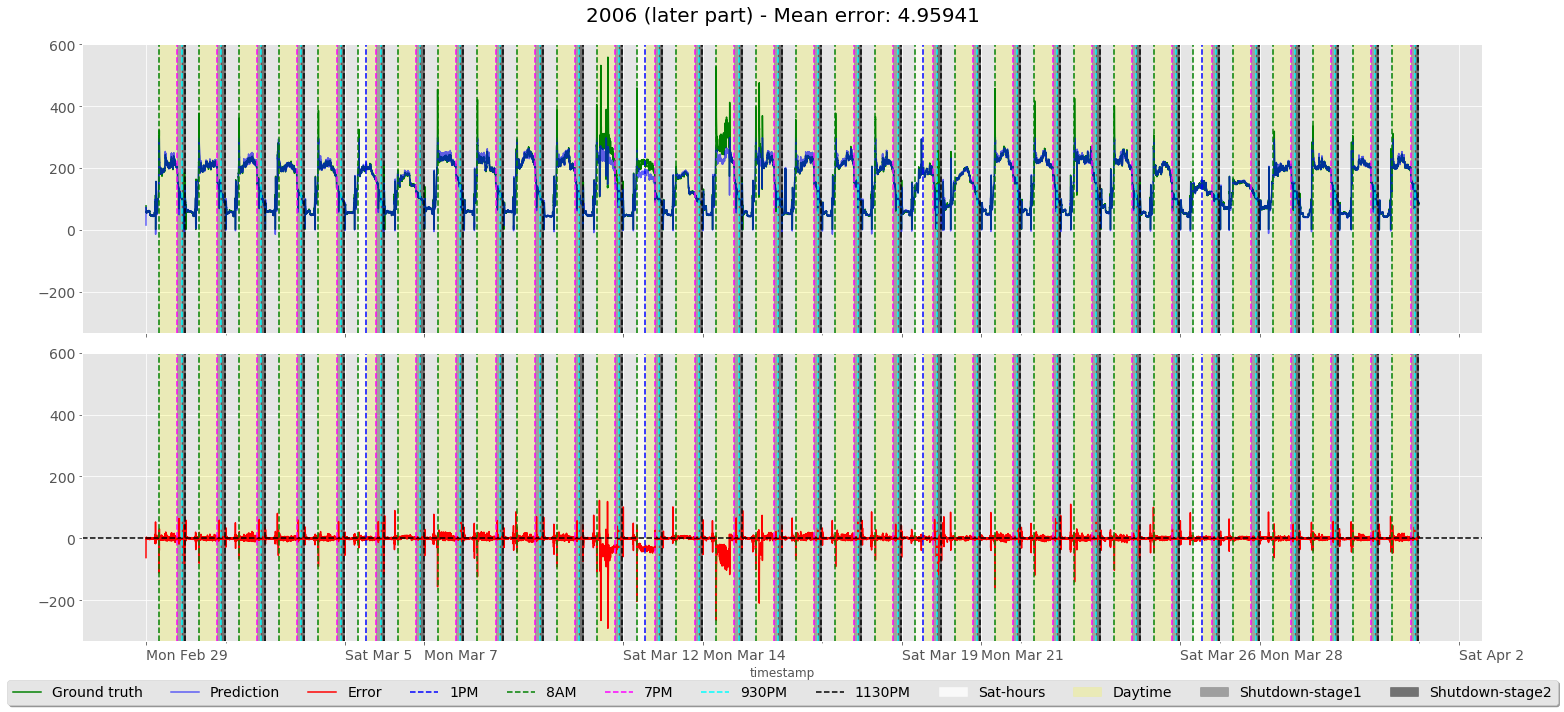

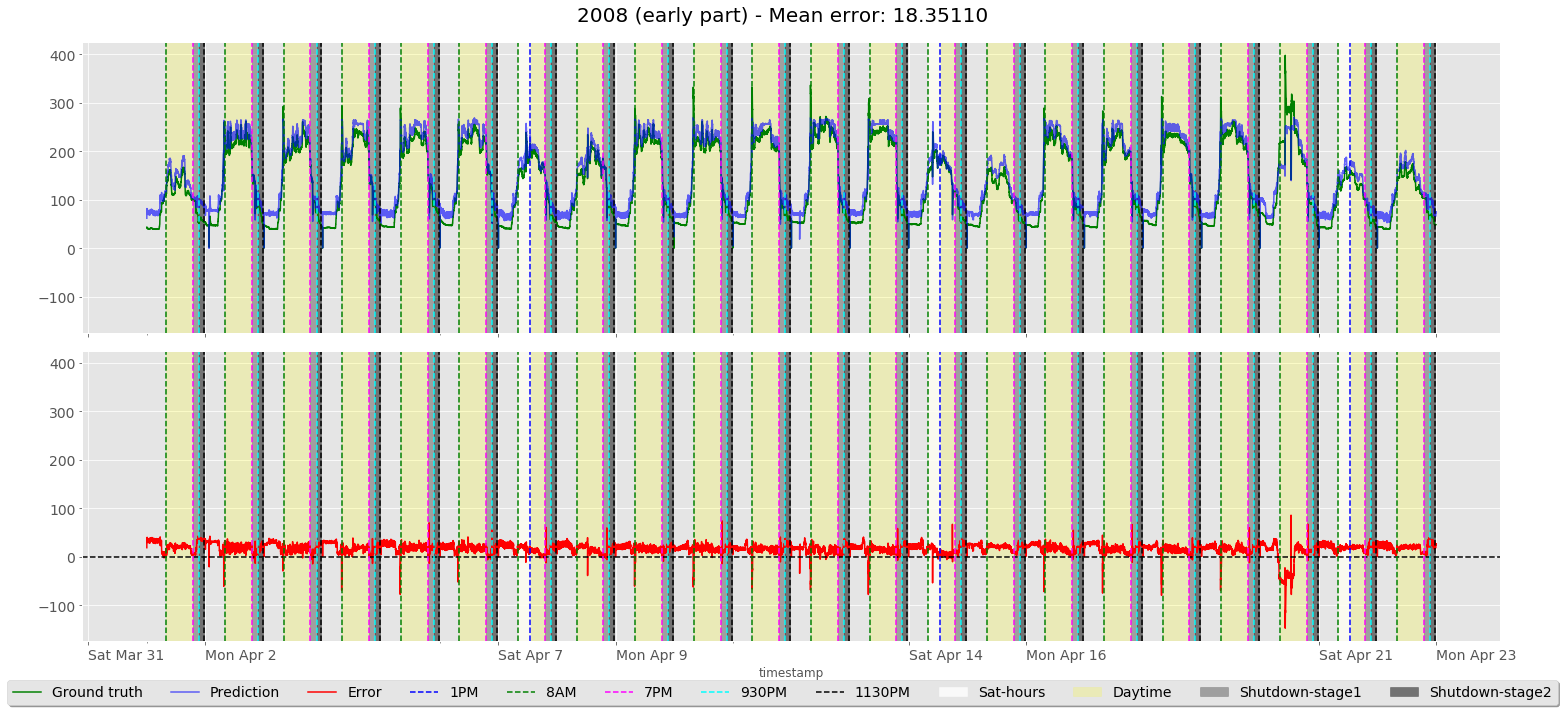

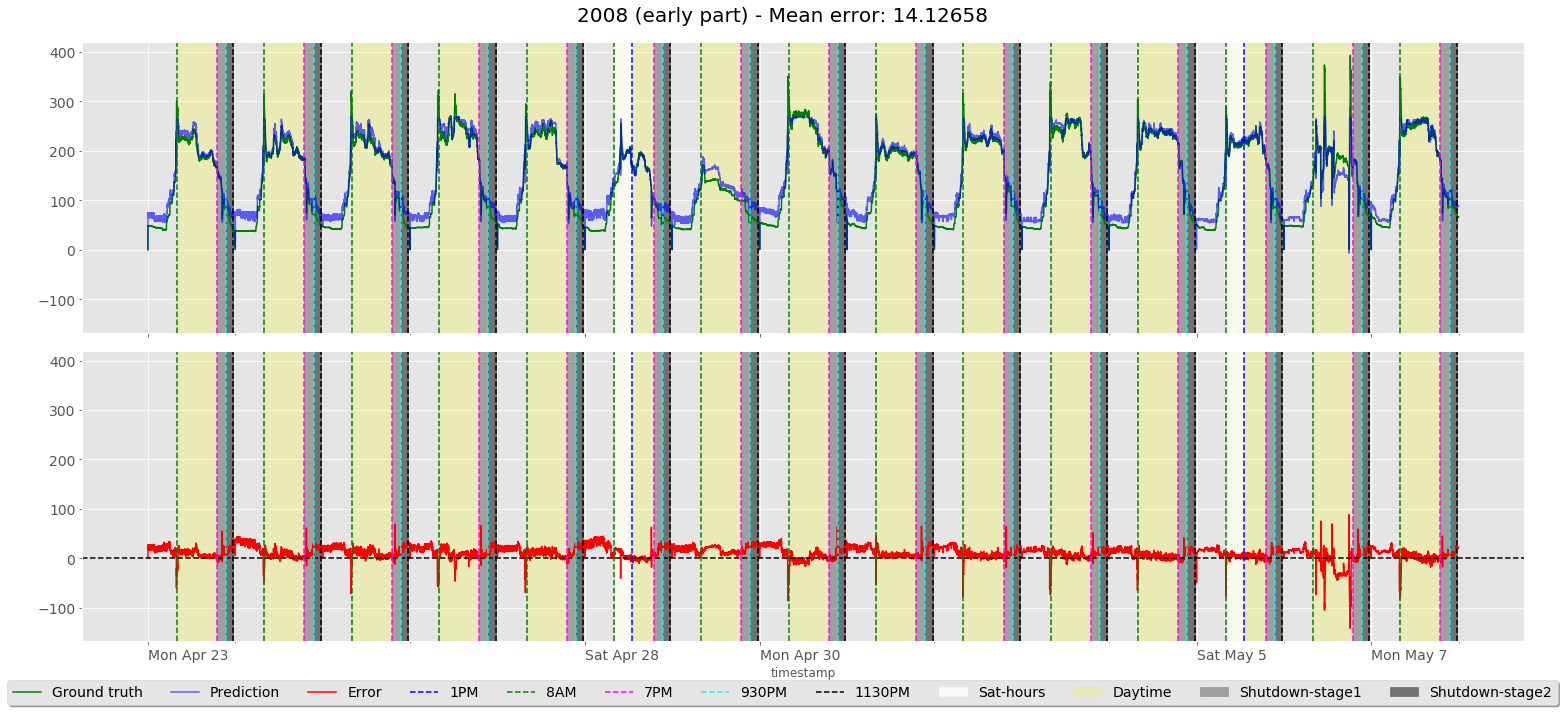

In [13]:
plot_model_error(y1_train, y1_train_pred, title="2016 (early part)")
plot_model_error(y1_test, y1_test_pred, title="2016 (later part)")
plot_model_error(y2_train, y2_train_pred, title="2018 (early part)")
plot_model_error(y2_test, y2_test_pred, title="2018 (early part)")

### Plot cumulative error

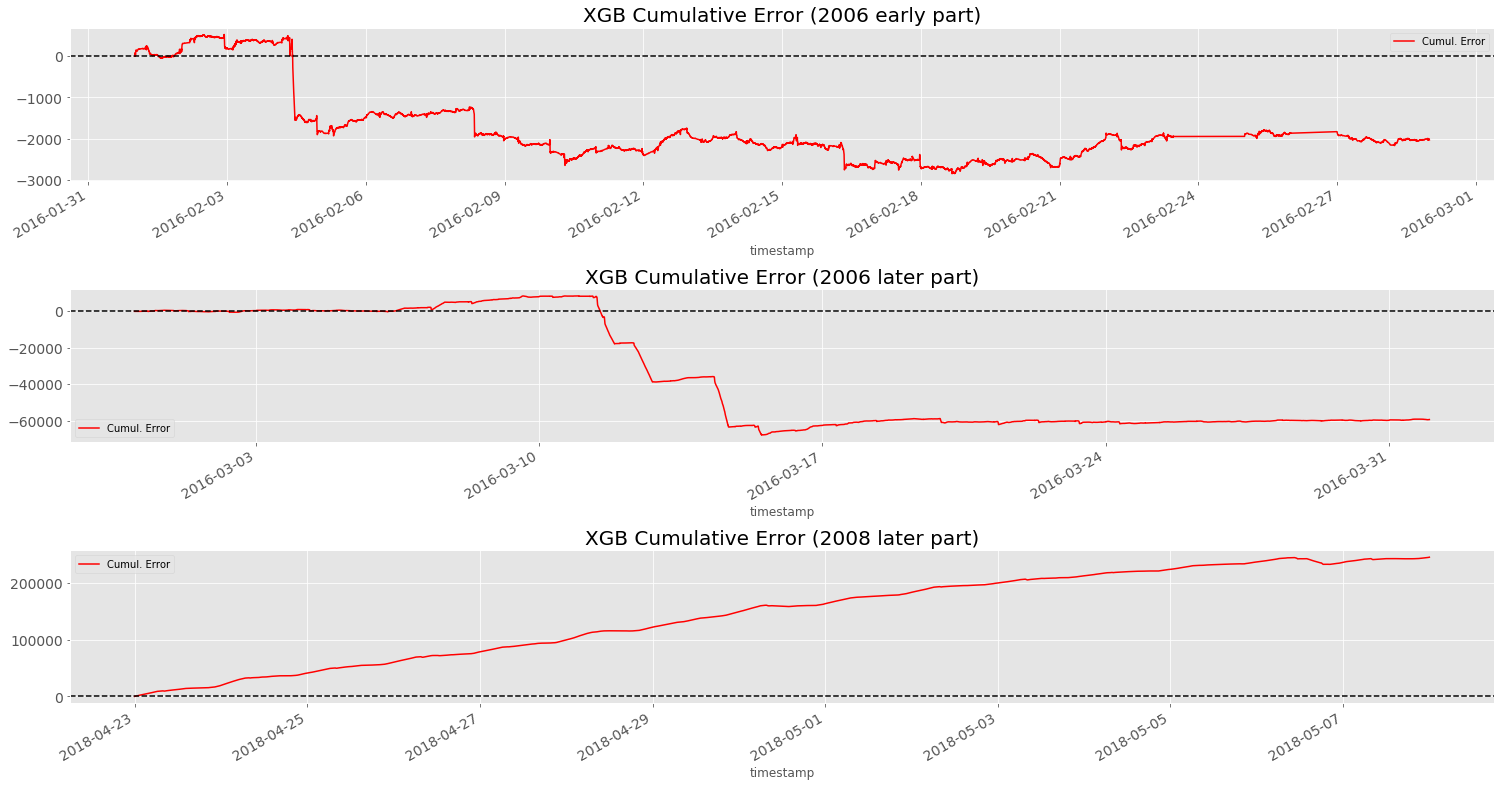

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cumul_error(y1_train, y1_train_pred, 
                 "XGB Cumulative Error (2016 early part)", ax=axes[0])
plot_cumul_error(y1_test, y1_test_pred, 
                 "XGB Cumulative Error (2016 later part)", ax=axes[1])
plot_cumul_error(y2_test, y2_test_pred, 
                 "XGB Cumulative Error (2018 later part)", ax=axes[2])

Interestingly, we see that this XGBoost model also **under predict** the output for the later part of 2016 and **over predict** for the year 2018.

Could the over prediction for the 2018 data be a sign that the **system has gotten less efficient?**

## GP

We try another probabilistic model - [Gaussian Process](https://sheffieldml.github.io/GPy/). This model is interesting because it can produce a measure of uncertainty along with each prediction.

The GP has trouble handling more than 10000 data points.
To work around this, we reduce the dataset to the first N_TRAIN examples in the sequence and use n_inducing pseudoinputs learned using the Sparse Gaussian Process.

In [15]:
from GPy.models import SparseGPRegression

N_TRAIN = 30000
n_inducing = 2000

dim = X1_train.shape[1]

k_white = GPy.kern.White(input_dim=dim, variance=10.0)
k_matern32 = GPy.kern.Matern32(input_dim=dim, variance=10.0, lengthscale=2000)
# We can add a white noise kernel 
# k = k_matern32 + k_white
k = k_matern32

gpr = SparseGPRegression(X=X1_train.values[:N_TRAIN], 
                         Y=y1_train.values[:N_TRAIN].reshape(-1, 1),
                         kernel=k,
                         num_inducing=n_inducing)

In [157]:
# Optimize hyperparaters using data
# This will take a very long time for large datasets (n >= 10000)
# This is **not** used in this notebook
# gpr.optimize_restarts(num_restarts=5)
gpr.optimize()

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

### Plot errors

Note that 2006 (early part) is also the **training** data.

In [16]:
y1_train_pred, y1_train_var = gpr.predict(X1_train.values)
y2_train_pred, y2_train_var = gpr.predict(X2_train.values)
y1_test_pred, y1_test_var = gpr.predict(X1_test.values)
y2_test_pred, y2_test_var = gpr.predict(X2_test.values)

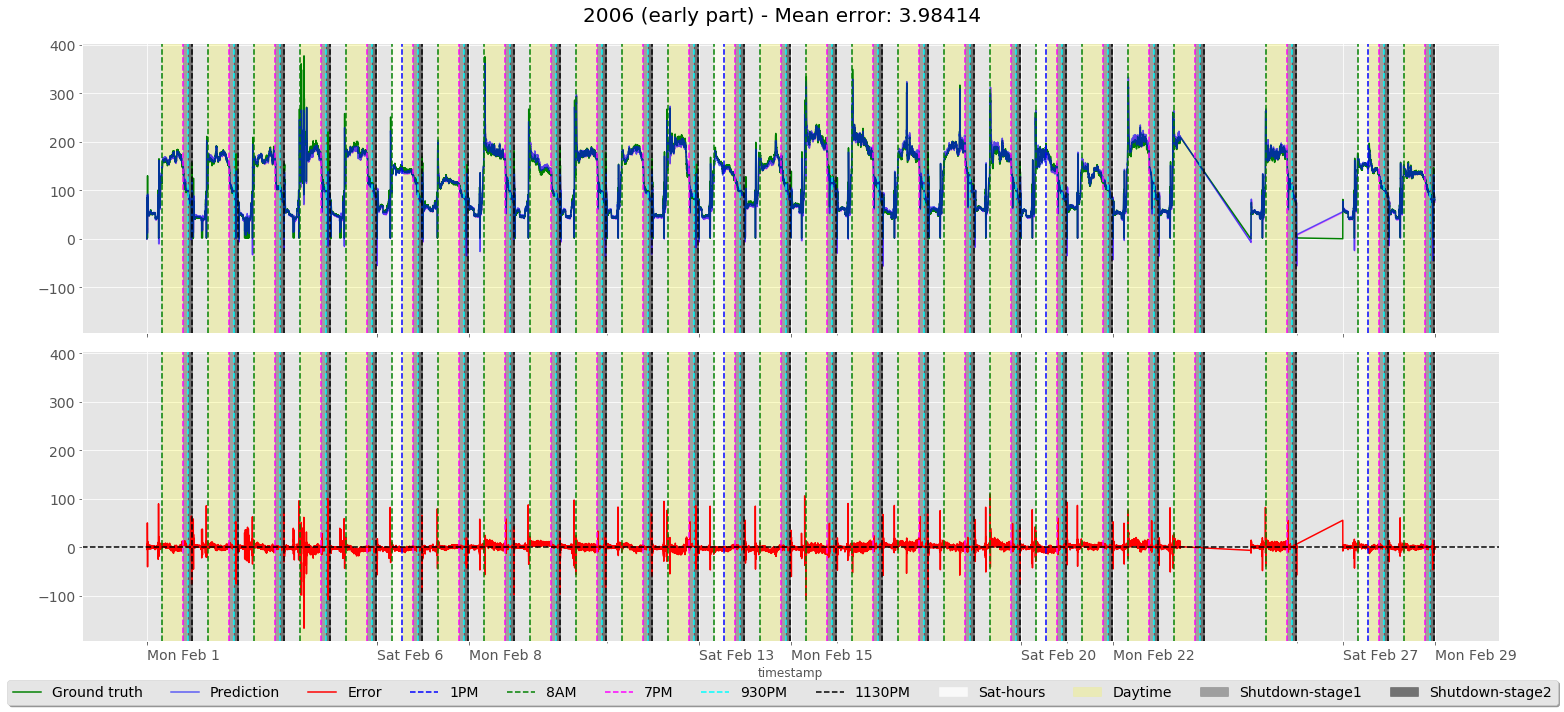

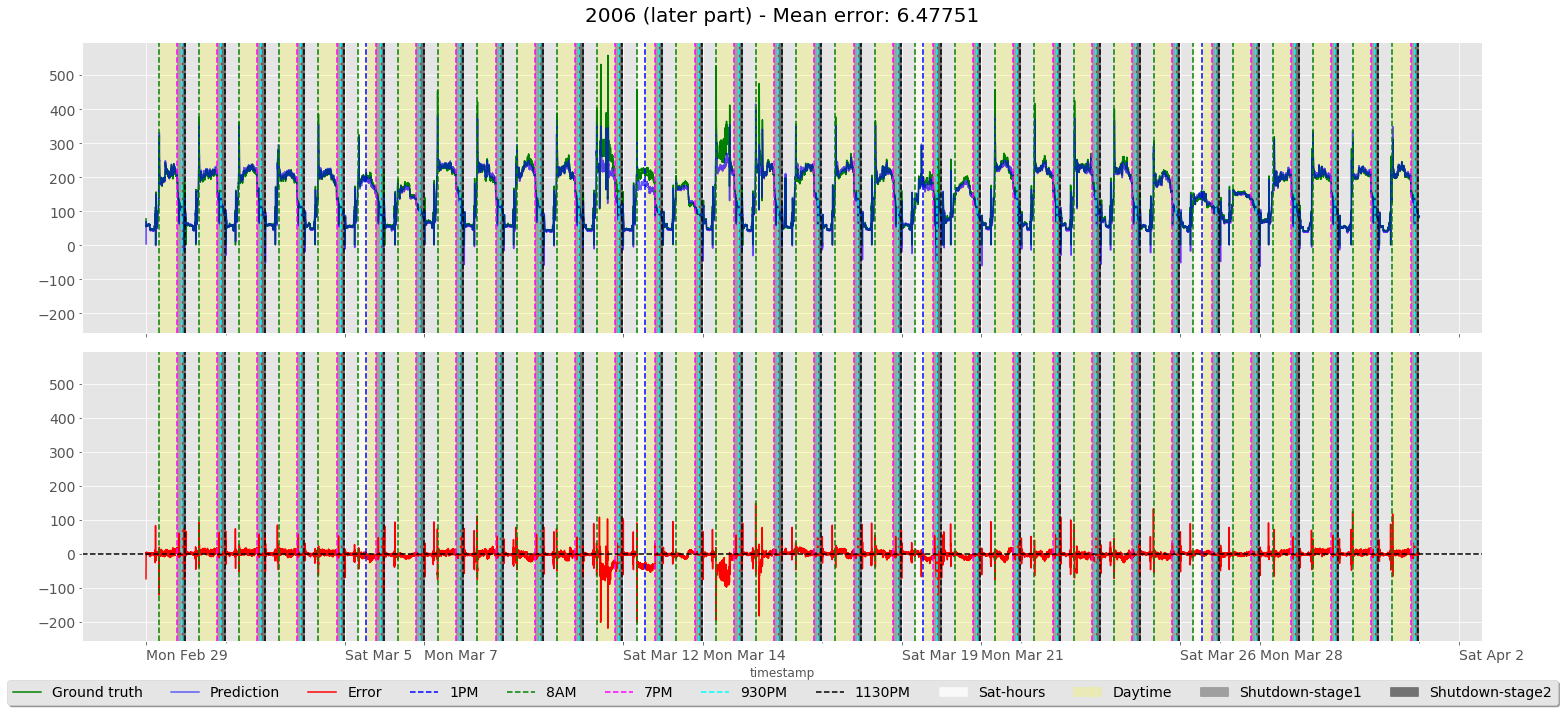

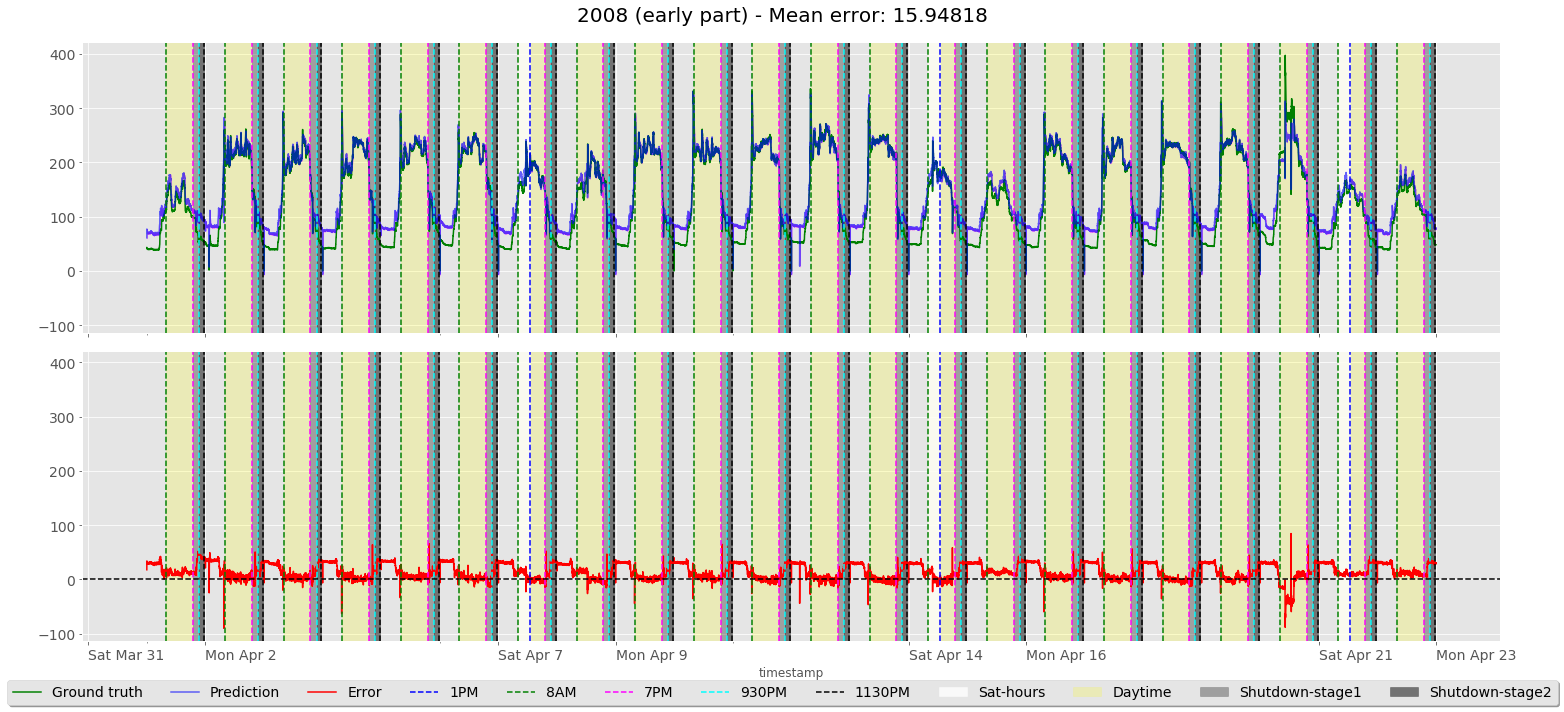

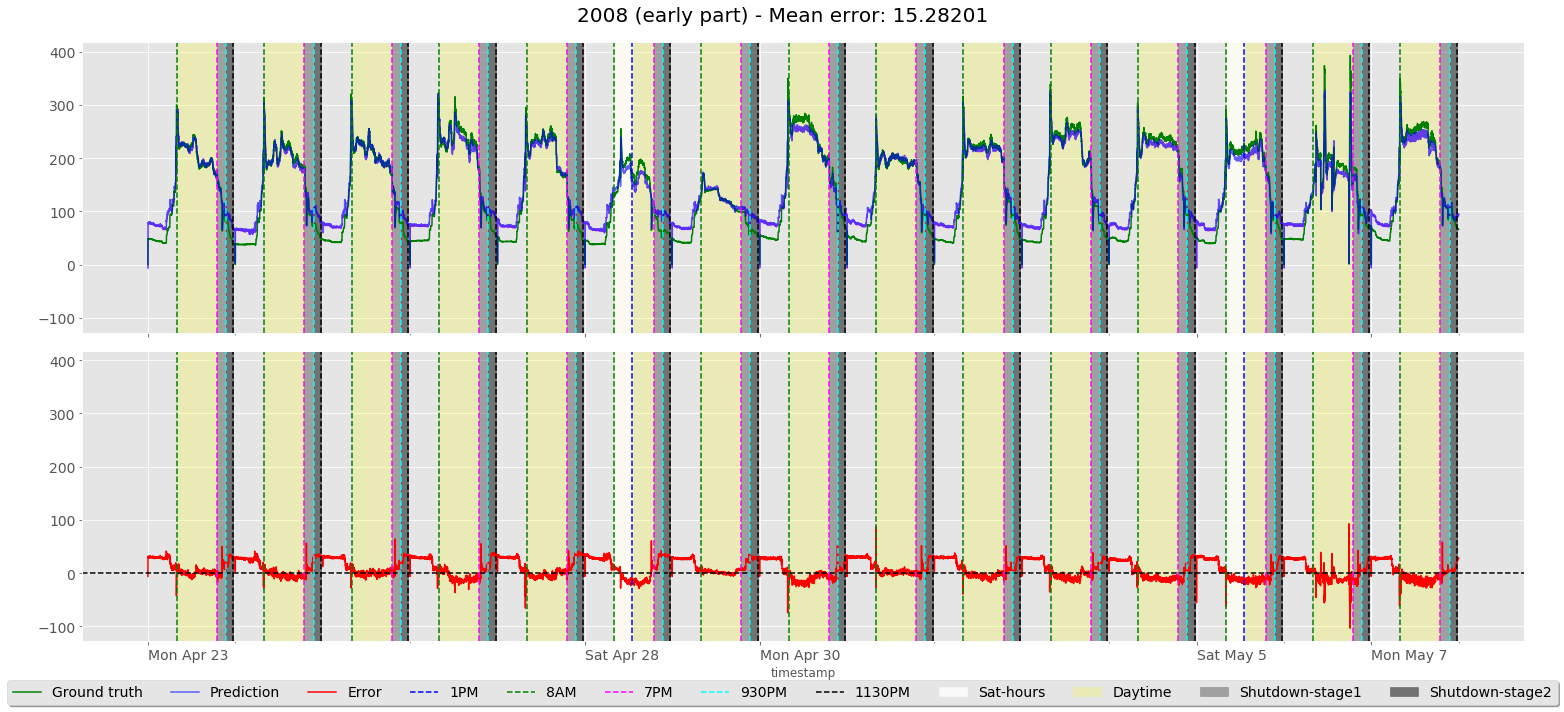

In [17]:
plot_model_error(y1_train, y1_train_pred, y1_train_var, title="2016 (early part)")
plot_model_error(y1_test, y1_test_pred, y1_test_var, title="2016 (later part)")
plot_model_error(y2_train, y2_train_pred, y2_train_var, title="2018 (early part)")
plot_model_error(y2_test, y2_test_pred, y2_test_var, title="2018 (early part)")

### Plot cumulative error

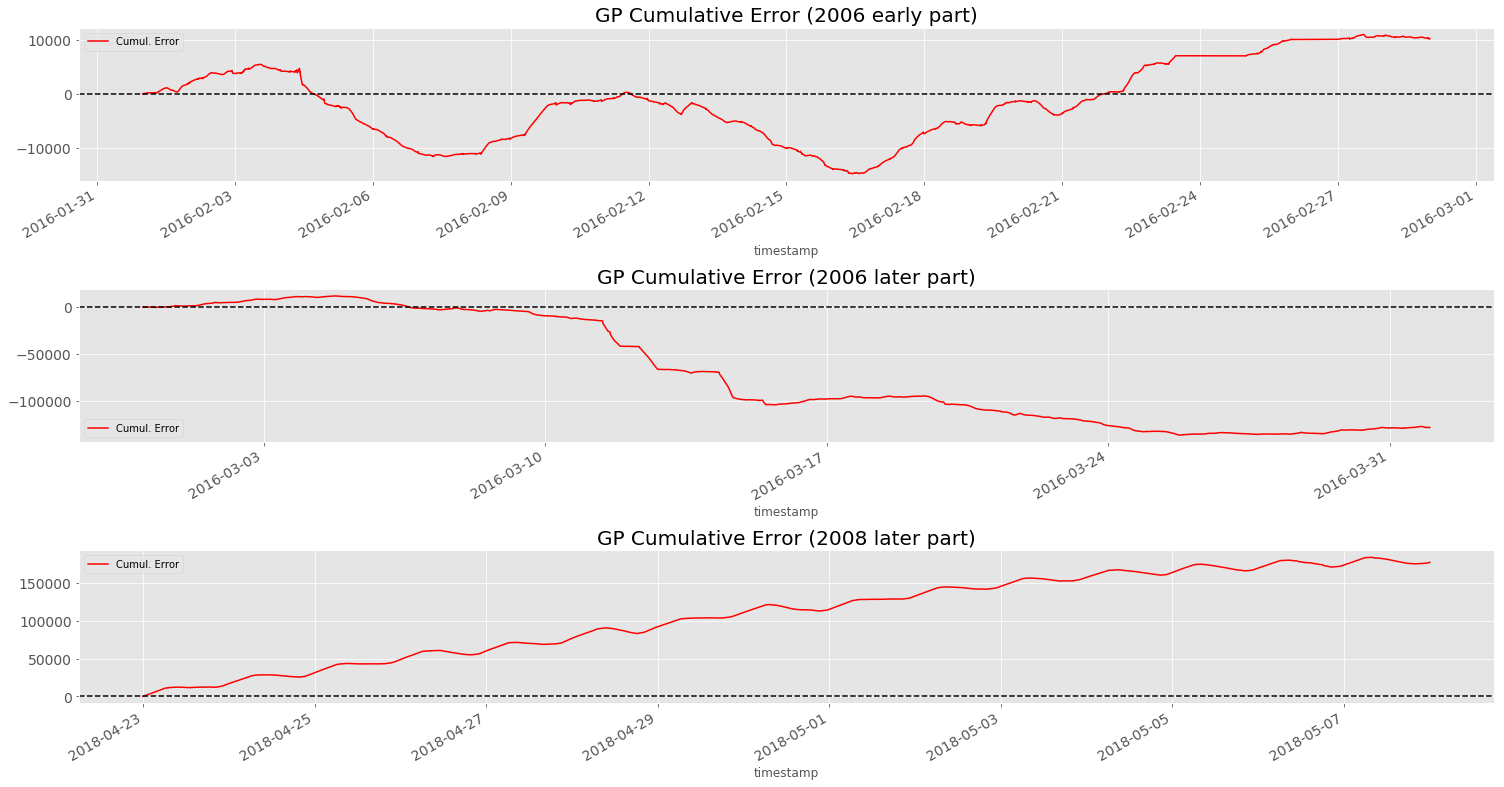

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cumul_error(y1_train, y1_train_pred, 
                 "GP Cumulative Error (2016 early part)", ax=axes[0])
plot_cumul_error(y1_test, y1_test_pred, 
                 "GP Cumulative Error (2016 later part)", ax=axes[1])
plot_cumul_error(y2_test, y2_test_pred, 
                 "GP Cumulative Error (2018 later part)", ax=axes[2])

Again, like the ridge regression and XGBoost model, we see that the Gaussian Process is also **under predicting** for the 2016 data and **over predicting** for the 2018 data.

However, we should not jump to conclusions here. As mentioned at the top of this document, the predictions are going to be sensitive to hyperparameter settings. Unless we understand the system, we should be careful in our analysis.

## GP with time information

We use an additional kernel to encourage observations that occur around the same time in the day and have similar inputs to have similar outputs. Time length scale is set to 3 hours so points >> 3 hours from each other will have diminishing influence on each other.

**Future work** can take into account the times the various chillers start to shutdown by using those times as **time-marked data**.

### Create time (in seconds) since midnight (12AM) as feature

In [7]:
from datetime import datetime

def day_elapsed_seconds(dt):
    """Number of seconds elapsed since epoch"""
    return float(dt.hour * 3600 + dt.minute * 60 + dt.second)

In [8]:
X1_train = X1_train.assign(time=X1_train.index.to_series().map(day_elapsed_seconds))
X1_test = X1_test.assign(time=X1_test.index.to_series().map(day_elapsed_seconds))
X2_train = X2_train.assign(time=X2_train.index.to_series().map(day_elapsed_seconds))
X2_test = X2_test.assign(time=X2_test.index.to_series().map(day_elapsed_seconds))

In [77]:
display_side_by_side(X1_train.head(1), X2_train.head(1))

chwshdr 
 cwrhdr 
 cwshdr 
 cwsfhdr 
 loadsys 
 chwsfhdr 
 time 
 
 
 timestamp 
 
 
 
 
 
 
 
 
 
 
 
 2016-02-01 
 0.0 
 30.4664 
 0.0 
 0.0 
 0.0 
 0.0 
 0 
 
 
 
 
 
 
 chwshdr 
 cwrhdr 
 cwshdr 
 cwsfhdr 
 loadsys 
 chwsfhdr 
 time 
 
 
 timestamp 
 
 
 
 
 
 
 
 
 
 
 
 2018-04-01 
 0.0 
 0.0 
 0.0 
 576.223 
 95.6832 
 486.972 
 0

In [11]:
import GPy
from GPy.kern import Matern32
from GPy.kern import RBF

from GPy.models import SparseGPRegression

N_TRAIN = 30000
n_inducing = 2000

dim = X1_train.shape[1]

k_matern32 = GPy.kern.Matern32(input_dim=dim - 1, variance=10.0, lengthscale=2000, 
                               active_dims=np.arange(dim - 1))
k_time = GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=3*60*60, 
                           active_dims=[dim - 1])

# Modulate similarity by only requiring similar inputs around the 
# same time of day to have similar outputs
k = k_time * k_matern32

gpr = SparseGPRegression(X=X1_train.values[:N_TRAIN], 
                         Y=y1_train.values[:N_TRAIN].reshape(-1, 1),
                         kernel=k,
                         num_inducing=n_inducing)

 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior w

 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior w

 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior w

 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior w

 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.


Best param: [1672.15423503  644.38526278 1779.97817982   37.38861271]


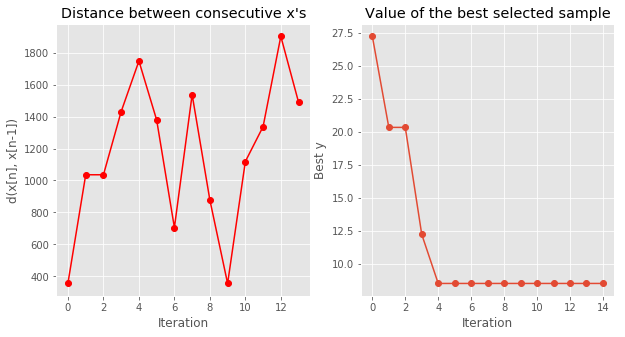

In [23]:
# Pick length scales 1, 2 and variance 1 and 2

import functools
from sklearn.base import BaseEstimator, ClassifierMixin
from GPy.kern import Matern32
from GPy.models import GPRegression, SparseGPRegression

class GpyRegressor(BaseEstimator, ClassifierMixin):
    """Scikit-Learn wrapper for GPyRegressor"""
    
    def __init__(self, lengthscale=1, variance=1, time_lengthscale=1, time_variance=1):
        self.lengthscale = lengthscale,
        self.variance = variance,
        self.time_lengthscale = time_lengthscale,
        self.time_variance = time_variance
                
    def fit(self, X, y):        
        assert X.shape[0] == len(y), "Number of training examples and labels must match."
        
        dim = X.shape[1]
        self.input_dim_ = dim
        
        self.data_kernel_ = Matern32(input_dim=dim - 1, 
                                     lengthscale=self.lengthscale, 
                                     variance=self.variance, 
                                     active_dims=np.arange(dim - 1))
        self.time_kernel_ = Matern32(input_dim=1, 
                                     lengthscale=self.time_lengthscale,
                                     variance=self.time_variance,
                                     active_dims=[dim - 1])        
        self.kernel_ = self.time_kernel_ * self.data_kernel_
                
        self.regressor_ = SparseGPRegression(X=X, 
                                             Y=y.reshape(-1, 1),
                                             kernel=self.kernel_,
                                             num_inducing=1000)
        
#         self.regressor_ = GPRegression(X=X, Y=y.reshape(-1, 1), kernel=self.kernel_) 
        
        return self
    
    def predict(self, X, y=None):        
        y_pred, _ = self.regressor_.predict(X)
        return y_pred

def f_gp(params, X, y, cv):
    params = params[0]
    lengthscale = params[0]
    variance = params[1]
    time_lengthscale = params[2]
    time_variance = params[3]
            
    score = -cross_val_score(GpyRegressor(lengthscale=lengthscale,
                                          variance=variance,
                                          time_lengthscale=time_lengthscale,
                                          time_variance=time_variance),
                             X, y,
                             cv=cv,
                             pre_dispatch=1,
                             scoring=SCORE_TYPE).mean()
    return np.array(score)


N_TRAIN = 20000
N_TIMESERIES_SPLITS = 3

np.random.seed(BO_RAND_STATE)
f = functools.partial(f_gp, 
                      X=X1_train.values[:N_TRAIN], 
                      y=y1_train.values[:N_TRAIN], 
                      cv=TimeSeriesSplit(n_splits=N_TIMESERIES_SPLITS))
gp_domains = [{'name': 'lengthscale', 'type': 'continuous', 'domain': (10, 2e3)},
              {'name': 'variance', 'type': 'continuous', 'domain': (1, 1e3)},
              {'name': 'time_lengthscale', 'type': 'continuous', 'domain': (0.1, 30*60)},
              {'name': 'time_variance', 'type': 'continuous', 'domain': (0.1, 1e2)},
             ]
optimizer = GPyOpt.methods.BayesianOptimization(f=f, 
                                                domain=gp_domains,
                                                acquisition_type='EI', # "LCB"
                                                acquisition_par=0.1,
                                                num_cores=1,
                                                exact_feval=False)

optimizer.run_optimization(max_iter=10)
print("Best param: {}".format(optimizer.x_opt))

optimizer.plot_convergence()

In [24]:
print("Best crossval score: {:.5f} best params: {}".format(optimizer.fx_opt, optimizer.x_opt))

Best crossval score: 8.49493 best params: [1672.15423503  644.38526278 1779.97817982   37.38861271]


In [48]:
import GPy
from GPy.kern import RBF

n_inducing = 1000

best_params = optimizer.x_opt

lengthscale = 2000 #best_params[0]
variance = 20 #best_params[1]
time_lengthscale = 3 * 60 #best_params[2]
time_variance = 1.0 #best_params[3]

dim = X1_train.shape[1]

k_matern32 = GPy.kern.Matern32(input_dim=dim - 1, 
                               variance=variance, 
                               lengthscale=lengthscale, 
                               active_dims=np.arange(dim - 1))

k_time = GPy.kern.Matern32(input_dim=1, 
                           variance=time_variance,
                           lengthscale=time_lengthscale,
                           active_dims=[dim - 1])

# We can also add a white noise kernel to ignore sharp spikes
# k = k_matern32 + k_white

# Modulate similarity by only requiring similar inputs close in time to have same output.
k = k_time * k_matern32

gpr = SparseGPRegression(X=X1_train.values[:N_TRAIN], 
                         Y=y1_train.values[:N_TRAIN].reshape(-1, 1),
                         kernel=k,
                         num_inducing=n_inducing)

### Plot errors

In [12]:
y1_train_pred, y1_train_var = gpr.predict(X1_train.values)
y2_train_pred, y2_train_var = gpr.predict(X2_train.values)
y1_test_pred, y1_test_var = gpr.predict(X1_test.values)
y2_test_pred, y2_test_var = gpr.predict(X2_test.values)

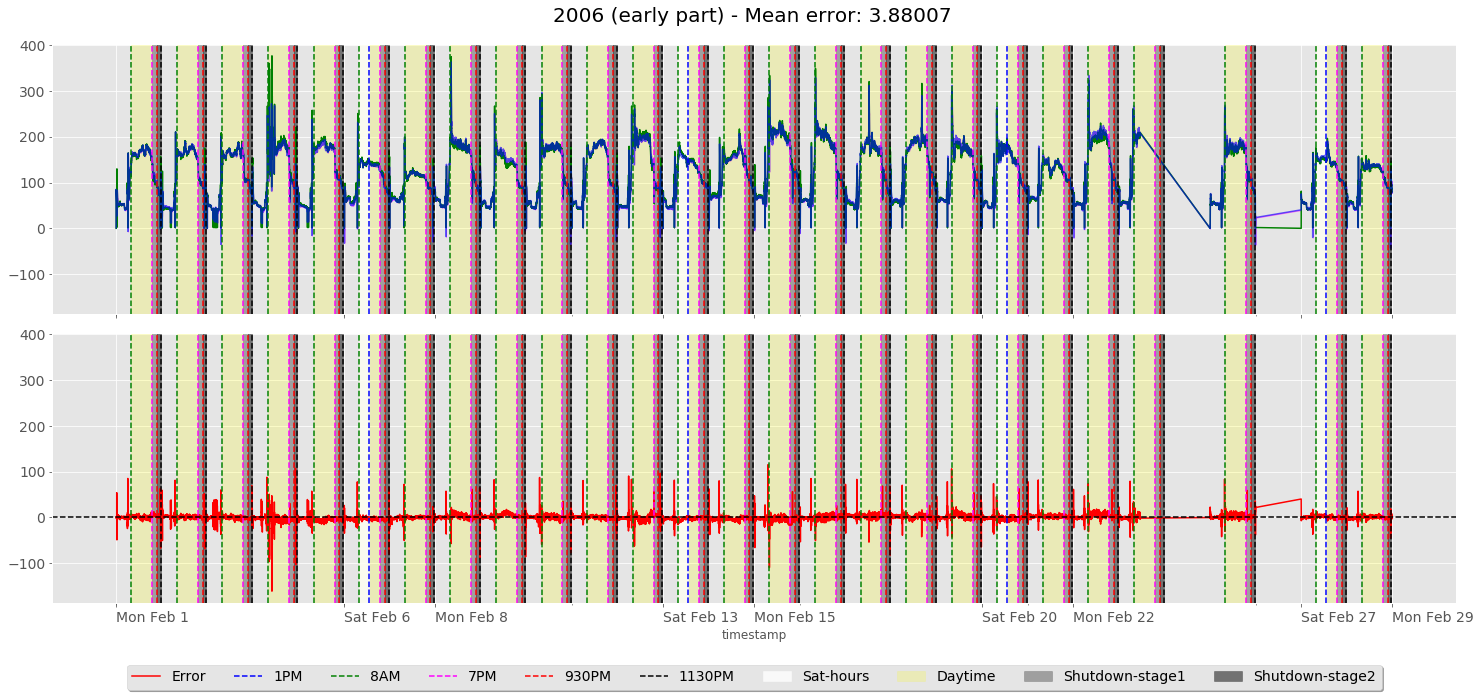

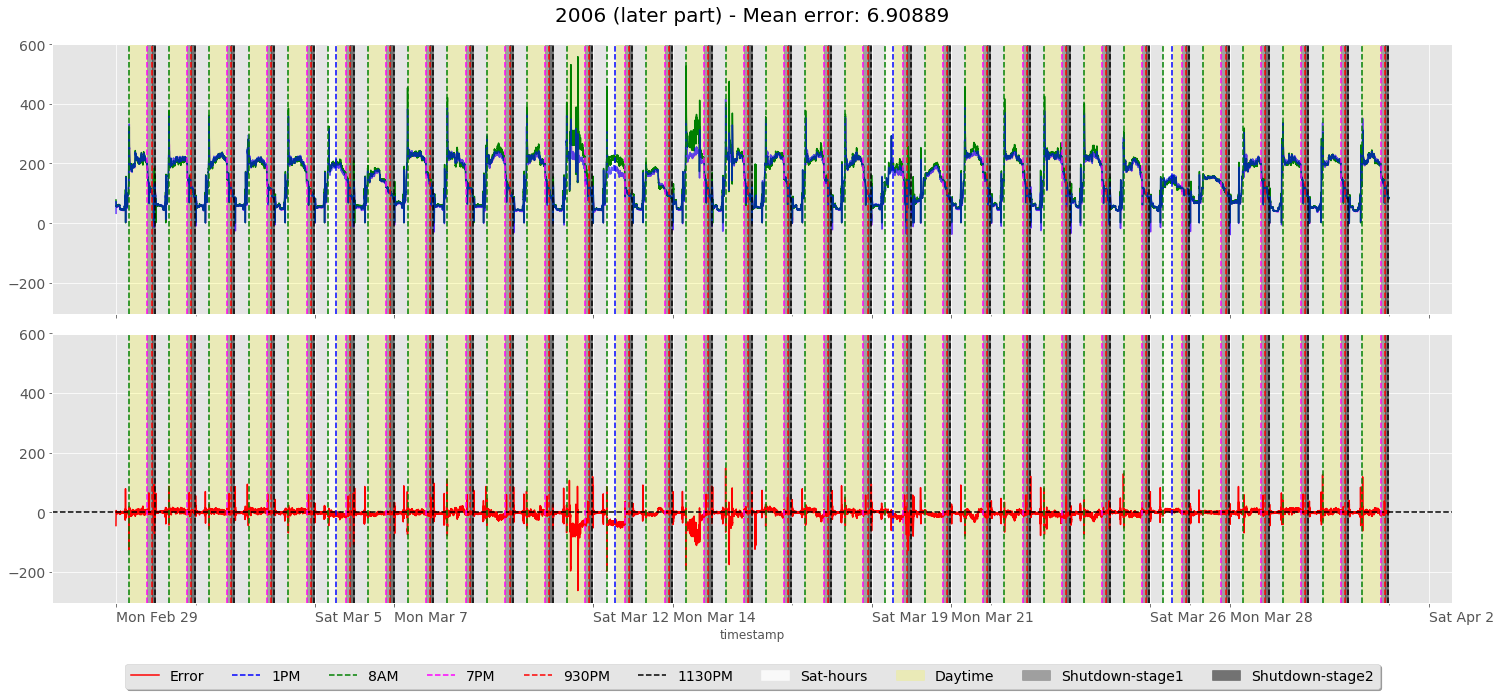

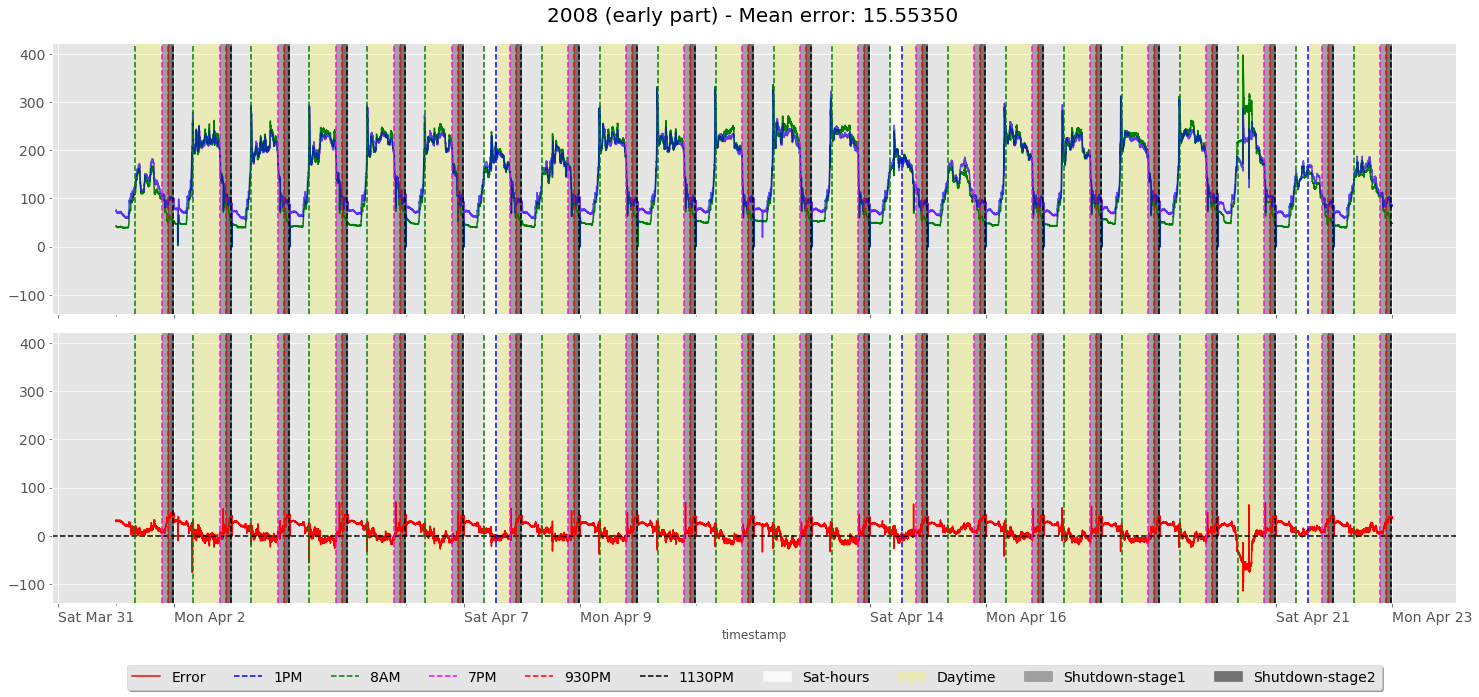

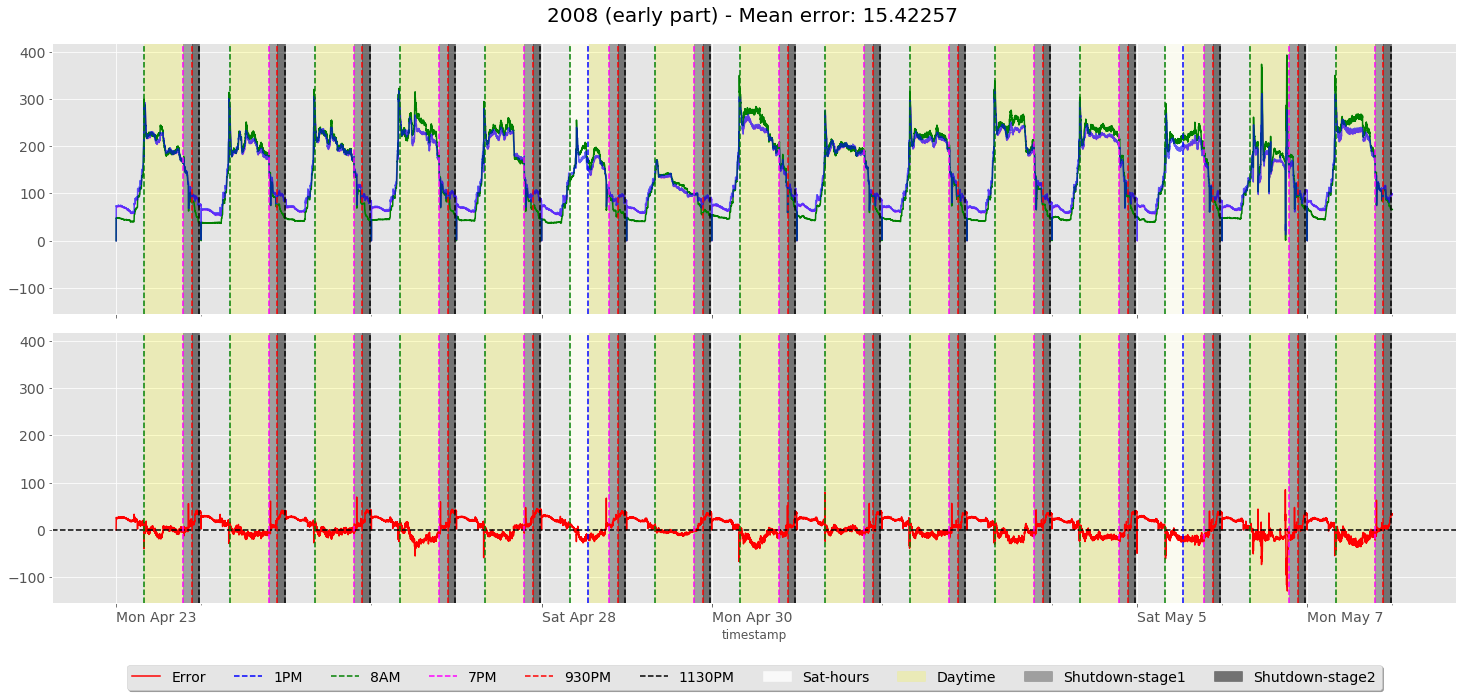

In [13]:
plot_model_error(y1_train, y1_train_pred, pred_variance=y1_train_var,
                 title="2016 (early part)")
plot_model_error(y1_test, y1_test_pred, pred_variance=y1_test_var,
                 title="2016 (later part)")
plot_model_error(y2_train, y2_train_pred, pred_variance=y2_train_var,
                 title="2018 (early part)")
plot_model_error(y2_test, y2_test_pred, pred_variance=y2_test_var,
                 title="2018 (early part)")

Result is not much better or much worse than GP model without this time kernel. This suggests, at least for this model, that time of day does not convey much information.

### Plot cumulative error

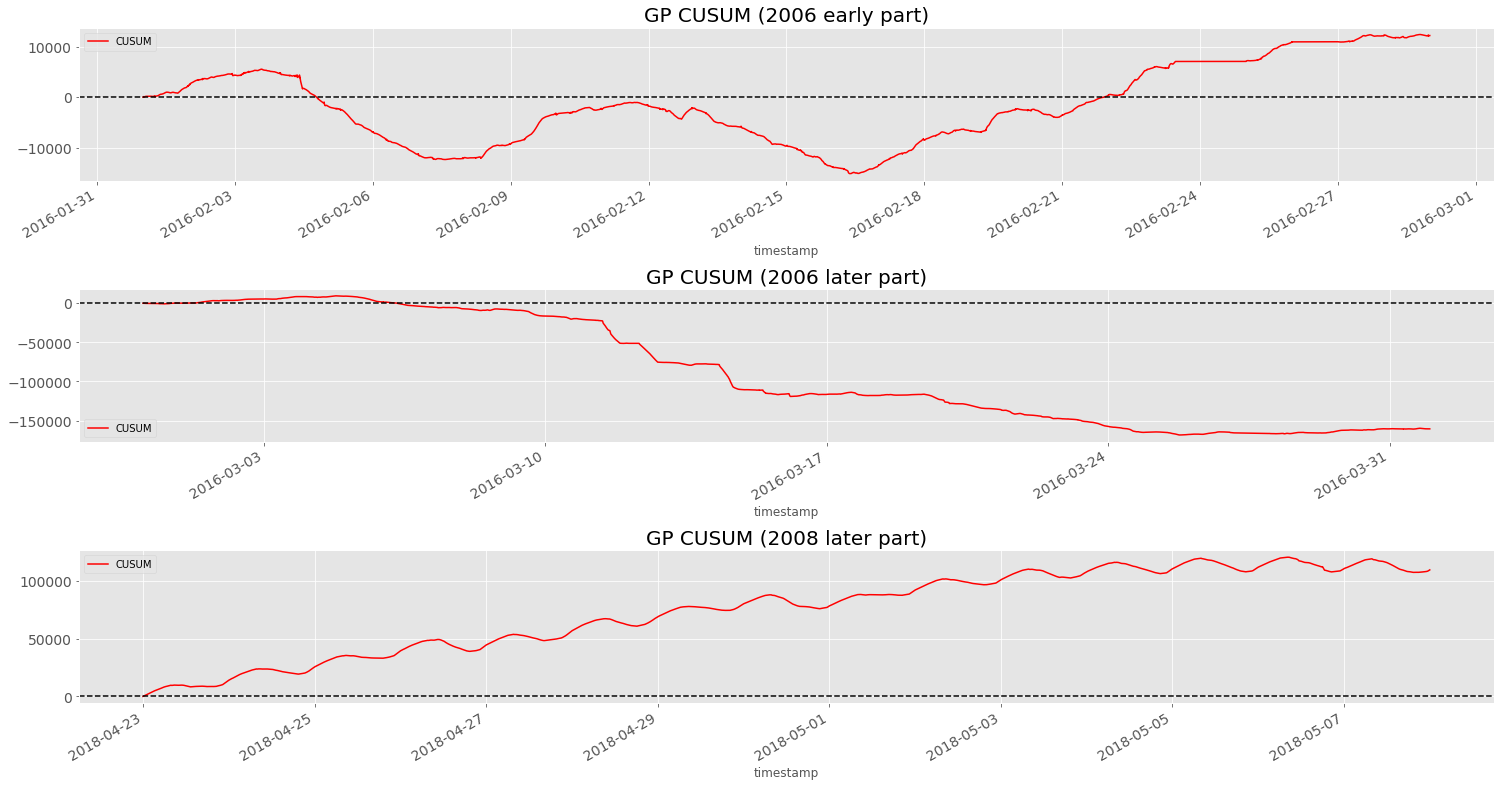

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cusum(y1_train, y1_train_pred, "GP CUSUM (2016 early part)", ax=axes[0])
plot_cusum(y1_test, y1_test_pred, "GP CUSUM (2016 later part)", ax=axes[1])
plot_cusum(y2_test, y2_test_pred, "GP CUSUM (2018 later part)", ax=axes[2])

# Distribution of error over time

We analyze the distribution of the error over time **for the ridge regression model** to check if there is some systematic errors in the predictions.

In [107]:
def plot_distribution_large_error_hist(y_true, y_pred, quantile=0.75, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    error = y_true.ravel() - y_pred.ravel()
    error = pd.Series(error, index=y_true.index)
    abs_error = error.abs()
    is_large_error = (abs_error >= abs_error.quantile(quantile))
    when_large_error = pd.DataFrame(abs_error.index[is_large_error].values,
                                    columns=["time"])
    when_large_errors.time.dt.hour.hist(bins=range(25), edgecolor="white", ax=ax)
        
    return ax

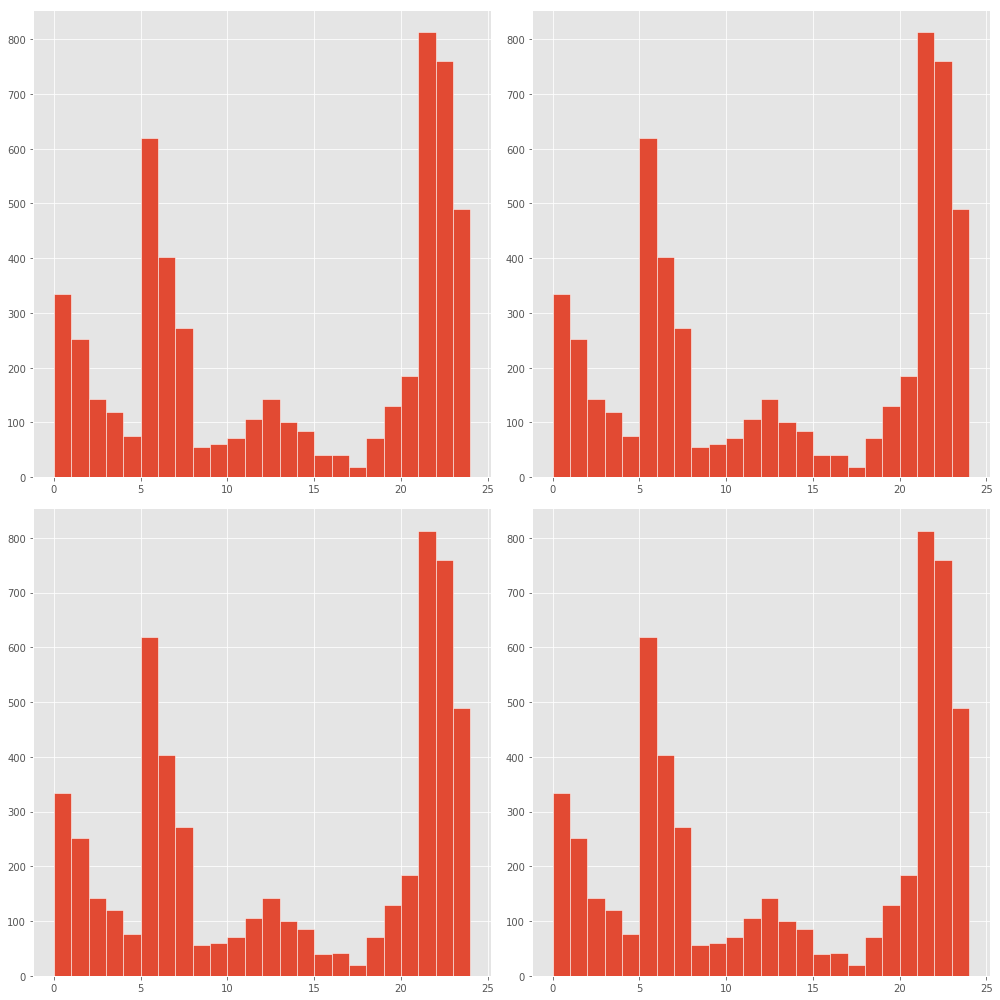

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
plot_distribution_large_error_hist(y1_train, y1_train_pred, 0.75, ax=axes[0, 0])
plot_distribution_large_error_hist(y1_test, y1_test_pred, 0.75, ax=axes[0, 1])
plot_distribution_large_error_hist(y2_test, y2_test_pred, 0.75, ax=axes[1, 0])
plot_distribution_large_error_hist(y2_test, y2_test_pred, 0.75, ax=axes[1, 1])

fig.tight_layout()

---